In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [9]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu
from suite3d import nbtools as nbui
from suite3d import extension as ext

# Define parameters and create job

In [11]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'CR031',
    'date' :          '2024-12-13',
    'expnum' :         [1,2],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22]),
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


In [12]:

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Loading job directory for CR031_2024-12-13_1-2 in /mnt/md0/runs
      Created dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/registered_fused_data
      Created dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/summary
      Created dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


# Run initial pass
Creates reference image and computes some initial parameters that are used later

In [13]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 4
job.params['init_n_frames'] = None
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (20, 2, 2)
job.params['fix_shallow_plane_shift_estimates'] = False

In [14]:
%%time
summary = job.run_init_pass()

   Saved a copy of params at /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00025.tif
    Loaded file into shared memory in 4.12 sec
    Workers completed in 0.69 sec
    Total time: 4.82 sec
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00050.tif
    Loaded file into shared memory in 4.07 sec
    Workers completed in 0.77 sec
    Total time: 4.84 sec
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00019.tif
    Loaded file into shared memory in 4.24 sec
    Workers completed in 0.95 sec
    Total time: 5.19 sec
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00044.tif
    Loaded file into shared memory in 4.10 sec
    Workers completed in 

In [15]:
summary = job.load_summary()
img = summary['ref_img_3d']

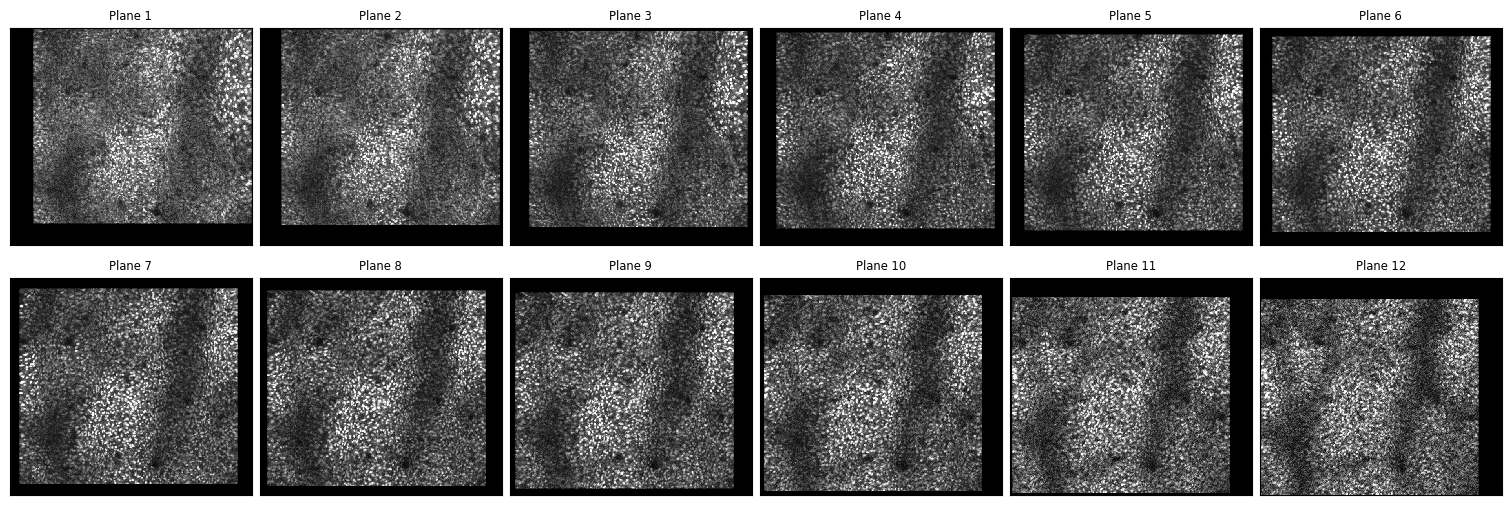

In [20]:
tfu.show_tif_all_planes(img, ncols = 6, figsize=(15,5))

In [21]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 400

# Motion correction

In [24]:
%%time
job.register()

      Found dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Overriding fuse shift value to 6
   Not clipping frames for registration
Will analyze 124 tifs in 124 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 146.813 GB, Virtual Available: 372.068 GB, Virtual Used: 131.127 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00001.tif
Loading Batch 0 of 123
    Loaded file into shared memory in 4.04 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.58 sec
    Total time: 5.61 sec
   Loaded 1 files, total 0.64 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 147.135 GB, Virtual Available: 371.746 GB, Virtual Used: 131.450 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.778 GB, Virtual Available: 371.103 GB, Virtual Used: 132.092 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 143.387 GB, Virtual Available: 375.494 GB, Virtual Used: 127.702 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 143.387 GB, Virtual Available: 375.494 GB, Virtual Used: 127.702 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00002.tif
   Completed rigid reg on batch in :1.6398422718048096s
   Shifted the mov in: 0.5393218994140625s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.54 sec
    Total time: 5.32 sec
   Loaded 1 files, total 0.64 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 146.574 GB, Virtual Available: 372.307 GB, Virtual Used: 130.888 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 145.687 GB, Virtual Available: 373.194 GB, Virtual Used: 130.001 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.043 GB, Virtual Available: 373.838 GB, Virtual Used: 129.357 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00003.tif
         After IO thread launch:Total Used: 145.043 GB, Virtual Available: 373.838 GB, Virtual Used: 129.357 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5686259269714355s
   Shifted the mov in: 0.5178728103637695s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.47 sec
   Loaded 1 files, total 0.64 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 146.402 GB, Virtual Available: 372.479 GB, Virtual Used: 130.716 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 145.524 GB, Virtual Available: 373.357 GB, Virtual Used: 129.839 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 144.874 GB, Virtual Available: 374.007 GB, Virtual Used: 129.188 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 144.874 GB, Virtual Available: 374.007 GB, Virtual Used: 129.188 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00004.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5791964530944824s
   Shifted the mov in: 0.5304596424102783s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.43 sec
   Loaded 1 files, total 0.64 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 146.702 GB, Virtual Available: 372.179 GB, Virtual Used: 131.017 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 145.677 GB, Virtual Available: 373.204 GB, Virtual Used: 129.991 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.028 GB, Virtual Available: 373.853 GB, Virtual Used: 129.342 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.028 GB, Virtual Available: 373.853 GB, Virtual Used: 129.342 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00005.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5689623355865479s
   Shifted the mov in: 0.5365397930145264s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.42 sec
   Loaded 1 files, total 0.64 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 149.130 GB, Virtual Available: 369.752 GB, Virtual Used: 133.444 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 148.247 GB, Virtual Available: 370.634 GB, Virtual Used: 132.562 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 147.600 GB, Virtual Available: 371.281 GB, Virtual Used: 131.915 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 147.600 GB, Virtual Available: 371.281 GB, Virtual Used: 131.915 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00006.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6131069660186768s
   Shifted the mov in: 0.5295822620391846s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.64 sec
    Total time: 5.44 sec
   Loaded 1 files, total 0.64 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 149.235 GB, Virtual Available: 369.646 GB, Virtual Used: 133.550 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 148.356 GB, Virtual Available: 370.525 GB, Virtual Used: 132.671 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 147.708 GB, Virtual Available: 371.174 GB, Virtual Used: 132.022 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 147.708 GB, Virtual Available: 371.174 GB, Virtual Used: 132.022 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00007.tif
   Completed rigid reg on batch in :1.5808637142181396s
   Shifted the mov in: 0.5193276405334473s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.50 sec
    Total time: 5.32 sec
   Loaded 1 files, total 0.64 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 147.657 GB, Virtual Available: 371.224 GB, Virtual Used: 131.971 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.778 GB, Virtual Available: 372.103 GB, Virtual Used: 131.092 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.129 GB, Virtual Available: 372.752 GB, Virtual Used: 130.443 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00008.tif
         After IO thread launch:Total Used: 146.129 GB, Virtual Available: 372.752 GB, Virtual Used: 130.443 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5865345001220703s
   Shifted the mov in: 0.5146520137786865s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.54 sec
    Total time: 5.33 sec
   Loaded 1 files, total 0.64 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 148.827 GB, Virtual Available: 370.054 GB, Virtual Used: 133.141 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.946 GB, Virtual Available: 370.935 GB, Virtual Used: 132.260 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 147.299 GB, Virtual Available: 371.583 GB, Virtual Used: 131.613 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00009.tif
         After IO thread launch:Total Used: 147.299 GB, Virtual Available: 371.583 GB, Virtual Used: 131.613 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5993738174438477s
   Shifted the mov in: 0.5213775634765625s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.40 sec
   Loaded 1 files, total 0.64 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 147.254 GB, Virtual Available: 371.628 GB, Virtual Used: 131.568 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.356 GB, Virtual Available: 372.525 GB, Virtual Used: 130.670 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.697 GB, Virtual Available: 373.184 GB, Virtual Used: 130.012 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.697 GB, Virtual Available: 373.184 GB, Virtual Used: 130.012 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00010.tif
   Completed rigid reg on batch in :1.596693754196167s
   Shifted the mov in: 0.5146481990814209s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.33 sec
   Loaded 1 files, total 0.64 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 148.822 GB, Virtual Available: 370.060 GB, Virtual Used: 133.136 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.935 GB, Virtual Available: 370.946 GB, Virtual Used: 132.250 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 147.302 GB, Virtual Available: 371.579 GB, Virtual Used: 131.616 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 147.302 GB, Virtual Available: 371.579 GB, Virtual Used: 131.616 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00011.tif
   Completed rigid reg on batch in :1.80751633644104s
   Shifted the mov in: 0.5625576972961426s
         After all GPU Batches:Total 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.38 sec
   Loaded 1 files, total 0.64 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 147.495 GB, Virtual Available: 371.387 GB, Virtual Used: 131.809 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.602 GB, Virtual Available: 372.279 GB, Virtual Used: 130.917 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.951 GB, Virtual Available: 372.930 GB, Virtual Used: 130.266 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00012.tif
         After IO thread launch:Total Used: 145.952 GB, Virtual Available: 372.929 GB, Virtual Used: 130.266 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.898895025253296s
   Shifted the mov in: 0.5466105937957764s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.50 sec
    Total time: 5.40 sec
   Loaded 1 files, total 0.64 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 148.369 GB, Virtual Available: 370.512 GB, Virtual Used: 132.684 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.492 GB, Virtual Available: 371.389 GB, Virtual Used: 131.806 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.844 GB, Virtual Available: 372.037 GB, Virtual Used: 131.158 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.844 GB, Virtual Available: 372.037 GB, Virtual Used: 131.158 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00013.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5975399017333984s
   Shifted the mov in: 0.5308303833007812s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.49 sec
    Total time: 5.30 sec
   Loaded 1 files, total 0.64 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 148.455 GB, Virtual Available: 370.426 GB, Virtual Used: 132.769 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.577 GB, Virtual Available: 371.304 GB, Virtual Used: 131.891 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.928 GB, Virtual Available: 371.953 GB, Virtual Used: 131.243 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.928 GB, Virtual Available: 371.953 GB, Virtual Used: 131.243 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00014.tif
   Completed rigid reg on batch in :1.611358642578125s
   Shifted the mov in: 0.5238239765167236s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.48 sec
    Total time: 5.31 sec
   Loaded 1 files, total 0.64 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 147.544 GB, Virtual Available: 371.337 GB, Virtual Used: 131.859 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.667 GB, Virtual Available: 372.214 GB, Virtual Used: 130.982 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.020 GB, Virtual Available: 372.861 GB, Virtual Used: 130.335 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.020 GB, Virtual Available: 372.861 GB, Virtual Used: 130.335 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00015.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6388893127441406s
   Shifted the mov in: 0.5429046154022217s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.50 sec
    Total time: 5.29 sec
   Loaded 1 files, total 0.64 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 147.623 GB, Virtual Available: 371.258 GB, Virtual Used: 131.938 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.745 GB, Virtual Available: 372.136 GB, Virtual Used: 131.060 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.096 GB, Virtual Available: 372.785 GB, Virtual Used: 130.411 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00016.tif
         After IO thread launch:Total Used: 146.096 GB, Virtual Available: 372.785 GB, Virtual Used: 130.411 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5888540744781494s
   Shifted the mov in: 0.5182068347930908s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.56 sec
    Total time: 5.38 sec
   Loaded 1 files, total 0.64 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 148.159 GB, Virtual Available: 370.723 GB, Virtual Used: 132.473 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.275 GB, Virtual Available: 371.606 GB, Virtual Used: 131.590 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.626 GB, Virtual Available: 372.255 GB, Virtual Used: 130.941 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.626 GB, Virtual Available: 372.255 GB, Virtual Used: 130.941 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00017.tif
   Completed rigid reg on batch in :1.6054878234863281s
   Shifted the mov in: 0.5328283309936523s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.59 sec
    Total time: 5.47 sec
   Loaded 1 files, total 0.64 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 147.784 GB, Virtual Available: 371.097 GB, Virtual Used: 132.099 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.895 GB, Virtual Available: 371.987 GB, Virtual Used: 131.209 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.253 GB, Virtual Available: 372.628 GB, Virtual Used: 130.568 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.253 GB, Virtual Available: 372.628 GB, Virtual Used: 130.568 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00018.tif
   Completed rigid reg on batch in :1.6005566120147705s
   Shifted the mov in: 0.5656414031982422s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.60 sec
    Total time: 5.64 sec
   Loaded 1 files, total 0.64 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 147.271 GB, Virtual Available: 371.610 GB, Virtual Used: 131.585 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.394 GB, Virtual Available: 372.487 GB, Virtual Used: 130.709 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.744 GB, Virtual Available: 373.137 GB, Virtual Used: 130.059 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.744 GB, Virtual Available: 373.137 GB, Virtual Used: 130.059 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00019.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6125226020812988s
   Shifted the mov in: 0.5498373508453369s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.68 sec
    Total time: 5.62 sec
   Loaded 1 files, total 0.64 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 147.359 GB, Virtual Available: 371.522 GB, Virtual Used: 131.674 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.481 GB, Virtual Available: 372.400 GB, Virtual Used: 130.795 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.832 GB, Virtual Available: 373.049 GB, Virtual Used: 130.146 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.832 GB, Virtual Available: 373.049 GB, Virtual Used: 130.146 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00020.tif
   Completed rigid reg on batch in :1.6046903133392334s
   Shifted the mov in: 0.5227029323577881s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.58 sec
    Total time: 5.44 sec
   Loaded 1 files, total 0.64 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 148.224 GB, Virtual Available: 370.658 GB, Virtual Used: 132.538 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.346 GB, Virtual Available: 371.535 GB, Virtual Used: 131.660 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.699 GB, Virtual Available: 372.182 GB, Virtual Used: 131.013 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.699 GB, Virtual Available: 372.182 GB, Virtual Used: 131.013 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00021.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6026413440704346s
   Shifted the mov in: 0.5407505035400391s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.64 sec
    Total time: 5.57 sec
   Loaded 1 files, total 0.64 GB
   Batch 20 IO thread joined
         Memory after IO thread joinTotal Used: 147.569 GB, Virtual Available: 371.312 GB, Virtual Used: 131.884 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.610 GB, Virtual Available: 372.271 GB, Virtual Used: 130.924 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.961 GB, Virtual Available: 372.920 GB, Virtual Used: 130.276 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.961 GB, Virtual Available: 372.920 GB, Virtual Used: 130.276 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00022.tif
   Completed rigid reg on batch in :1.6015903949737549s
   Shifted the mov in: 0.5577213764190674s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.63 sec
   Loaded 1 files, total 0.64 GB
   Batch 21 IO thread joined
         Memory after IO thread joinTotal Used: 148.074 GB, Virtual Available: 370.808 GB, Virtual Used: 132.388 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.187 GB, Virtual Available: 371.695 GB, Virtual Used: 131.501 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.544 GB, Virtual Available: 372.337 GB, Virtual Used: 130.858 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.544 GB, Virtual Available: 372.337 GB, Virtual Used: 130.858 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00023.tif
   Completed rigid reg on batch in :1.5969617366790771s
   Shifted the mov in: 0.5694715976715088s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.73 sec
    Total time: 5.56 sec
   Loaded 1 files, total 0.64 GB
   Batch 22 IO thread joined
         Memory after IO thread joinTotal Used: 147.551 GB, Virtual Available: 371.330 GB, Virtual Used: 131.865 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.659 GB, Virtual Available: 372.222 GB, Virtual Used: 130.974 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.013 GB, Virtual Available: 372.868 GB, Virtual Used: 130.328 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00024.tif
         After IO thread launch:Total Used: 146.013 GB, Virtual Available: 372.868 GB, Virtual Used: 130.328 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5996313095092773s
   Shifted the mov in: 0.570451021194458s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.62 sec
   Loaded 1 files, total 0.64 GB
   Batch 23 IO thread joined
         Memory after IO thread joinTotal Used: 147.833 GB, Virtual Available: 371.048 GB, Virtual Used: 132.147 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.954 GB, Virtual Available: 371.927 GB, Virtual Used: 131.269 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.306 GB, Virtual Available: 372.576 GB, Virtual Used: 130.620 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.306 GB, Virtual Available: 372.576 GB, Virtual Used: 130.620 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00025.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5975706577301025s
   Shifted the mov in: 0.5485167503356934s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.72 sec
    Total time: 5.61 sec
   Loaded 1 files, total 0.64 GB
   Batch 24 IO thread joined
         Memory after IO thread joinTotal Used: 147.608 GB, Virtual Available: 371.273 GB, Virtual Used: 131.923 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.722 GB, Virtual Available: 372.159 GB, Virtual Used: 131.037 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.084 GB, Virtual Available: 372.797 GB, Virtual Used: 130.398 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.084 GB, Virtual Available: 372.797 GB, Virtual Used: 130.398 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00026.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6439728736877441s
   Shifted the mov in: 0.5712690353393555s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.69 sec
    Total time: 5.74 sec
   Loaded 1 files, total 0.64 GB
   Batch 25 IO thread joined
         Memory after IO thread joinTotal Used: 147.700 GB, Virtual Available: 371.182 GB, Virtual Used: 132.014 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.817 GB, Virtual Available: 372.064 GB, Virtual Used: 131.132 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.170 GB, Virtual Available: 372.711 GB, Virtual Used: 130.485 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.170 GB, Virtual Available: 372.711 GB, Virtual Used: 130.485 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00027.tif
   Completed rigid reg on batch in :1.6278741359710693s
   Shifted the mov in: 0.527435302734375s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.63 sec
    Total time: 5.45 sec
   Loaded 1 files, total 0.64 GB
   Batch 26 IO thread joined
         Memory after IO thread joinTotal Used: 147.539 GB, Virtual Available: 371.343 GB, Virtual Used: 131.853 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.661 GB, Virtual Available: 372.220 GB, Virtual Used: 130.976 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.014 GB, Virtual Available: 372.867 GB, Virtual Used: 130.329 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00028.tif
         After IO thread launch:Total Used: 146.014 GB, Virtual Available: 372.867 GB, Virtual Used: 130.329 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6142520904541016s
   Shifted the mov in: 0.5332410335540771s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.49 sec
   Loaded 1 files, total 0.64 GB
   Batch 27 IO thread joined
         Memory after IO thread joinTotal Used: 147.622 GB, Virtual Available: 371.259 GB, Virtual Used: 131.936 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.743 GB, Virtual Available: 372.138 GB, Virtual Used: 131.057 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.094 GB, Virtual Available: 372.787 GB, Virtual Used: 130.408 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.094 GB, Virtual Available: 372.787 GB, Virtual Used: 130.408 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00029.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.595719575881958s
   Shifted the mov in: 0.5121490955352783s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.60 sec
    Total time: 5.41 sec
   Loaded 1 files, total 0.64 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 147.664 GB, Virtual Available: 371.217 GB, Virtual Used: 131.978 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.779 GB, Virtual Available: 372.102 GB, Virtual Used: 131.093 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.134 GB, Virtual Available: 372.747 GB, Virtual Used: 130.448 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.134 GB, Virtual Available: 372.747 GB, Virtual Used: 130.448 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00030.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6267726421356201s
   Shifted the mov in: 0.5282406806945801s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.61 sec
    Total time: 5.52 sec
   Loaded 1 files, total 0.64 GB
   Batch 29 IO thread joined
         Memory after IO thread joinTotal Used: 147.755 GB, Virtual Available: 371.126 GB, Virtual Used: 132.070 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.877 GB, Virtual Available: 372.004 GB, Virtual Used: 131.192 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.230 GB, Virtual Available: 372.651 GB, Virtual Used: 130.544 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.230 GB, Virtual Available: 372.651 GB, Virtual Used: 130.544 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00031.tif
   Completed rigid reg on batch in :1.618973731994629s
   Shifted the mov in: 0.5181725025177002s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.36 sec
   Loaded 1 files, total 0.64 GB
   Batch 30 IO thread joined
         Memory after IO thread joinTotal Used: 147.256 GB, Virtual Available: 371.626 GB, Virtual Used: 131.570 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.378 GB, Virtual Available: 372.503 GB, Virtual Used: 130.693 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.732 GB, Virtual Available: 373.150 GB, Virtual Used: 130.046 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.732 GB, Virtual Available: 373.150 GB, Virtual Used: 130.046 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00032.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6327214241027832s
   Shifted the mov in: 0.5581939220428467s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.56 sec
    Total time: 5.42 sec
   Loaded 1 files, total 0.64 GB
   Batch 31 IO thread joined
         Memory after IO thread joinTotal Used: 147.345 GB, Virtual Available: 371.536 GB, Virtual Used: 131.659 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.463 GB, Virtual Available: 372.418 GB, Virtual Used: 130.778 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.809 GB, Virtual Available: 373.072 GB, Virtual Used: 130.123 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.809 GB, Virtual Available: 373.072 GB, Virtual Used: 130.123 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00033.tif
   Completed rigid reg on batch in :1.622636318206787s
   Shifted the mov in: 0.5285847187042236s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.57 sec
    Total time: 5.40 sec
   Loaded 1 files, total 0.64 GB
   Batch 32 IO thread joined
         Memory after IO thread joinTotal Used: 147.743 GB, Virtual Available: 371.138 GB, Virtual Used: 132.057 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.865 GB, Virtual Available: 372.016 GB, Virtual Used: 131.179 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.220 GB, Virtual Available: 372.661 GB, Virtual Used: 130.534 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.220 GB, Virtual Available: 372.661 GB, Virtual Used: 130.534 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00034.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6112027168273926s
   Shifted the mov in: 0.5687613487243652s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.55 sec
    Total time: 5.44 sec
   Loaded 1 files, total 0.64 GB
   Batch 33 IO thread joined
         Memory after IO thread joinTotal Used: 147.276 GB, Virtual Available: 371.606 GB, Virtual Used: 131.590 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.397 GB, Virtual Available: 372.484 GB, Virtual Used: 130.711 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.748 GB, Virtual Available: 373.133 GB, Virtual Used: 130.062 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.748 GB, Virtual Available: 373.133 GB, Virtual Used: 130.062 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00035.tif
   Completed rigid reg on batch in :1.6119170188903809s
   Shifted the mov in: 0.5316107273101807s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.55 sec
    Total time: 5.41 sec
   Loaded 1 files, total 0.64 GB
   Batch 34 IO thread joined
         Memory after IO thread joinTotal Used: 147.831 GB, Virtual Available: 371.050 GB, Virtual Used: 132.145 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.952 GB, Virtual Available: 371.929 GB, Virtual Used: 131.267 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.304 GB, Virtual Available: 372.578 GB, Virtual Used: 130.618 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.305 GB, Virtual Available: 372.576 GB, Virtual Used: 130.619 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00036.tif
   Completed rigid reg on batch in :1.9070830345153809s
   Shifted the mov in: 0.5973372459411621s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.55 sec
    Total time: 5.52 sec
   Loaded 1 files, total 0.64 GB
   Batch 35 IO thread joined
         Memory after IO thread joinTotal Used: 147.273 GB, Virtual Available: 371.608 GB, Virtual Used: 131.588 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.396 GB, Virtual Available: 372.485 GB, Virtual Used: 130.711 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.750 GB, Virtual Available: 373.131 GB, Virtual Used: 130.065 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00037.tif
         After IO thread launch:Total Used: 145.750 GB, Virtual Available: 373.131 GB, Virtual Used: 130.065 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6178009510040283s
   Shifted the mov in: 0.5501394271850586s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.75 sec
    Total time: 5.63 sec
   Loaded 1 files, total 0.64 GB
   Batch 36 IO thread joined
         Memory after IO thread joinTotal Used: 147.353 GB, Virtual Available: 371.529 GB, Virtual Used: 131.667 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.474 GB, Virtual Available: 372.407 GB, Virtual Used: 130.789 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.828 GB, Virtual Available: 373.054 GB, Virtual Used: 130.142 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.828 GB, Virtual Available: 373.054 GB, Virtual Used: 130.142 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00038.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6278574466705322s
   Shifted the mov in: 0.5297126770019531s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.63 sec
    Total time: 5.51 sec
   Loaded 1 files, total 0.64 GB
   Batch 37 IO thread joined
         Memory after IO thread joinTotal Used: 147.369 GB, Virtual Available: 371.512 GB, Virtual Used: 131.684 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.483 GB, Virtual Available: 372.398 GB, Virtual Used: 130.797 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.834 GB, Virtual Available: 373.047 GB, Virtual Used: 130.148 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.834 GB, Virtual Available: 373.047 GB, Virtual Used: 130.148 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00039.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5885710716247559s
   Shifted the mov in: 0.5190651416778564s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.59 sec
    Total time: 5.45 sec
   Loaded 1 files, total 0.64 GB
   Batch 38 IO thread joined
         Memory after IO thread joinTotal Used: 147.670 GB, Virtual Available: 371.211 GB, Virtual Used: 131.985 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.782 GB, Virtual Available: 372.100 GB, Virtual Used: 131.096 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.142 GB, Virtual Available: 372.739 GB, Virtual Used: 130.457 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.142 GB, Virtual Available: 372.739 GB, Virtual Used: 130.457 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00040.tif
   Completed rigid reg on batch in :1.626542091369629s
   Shifted the mov in: 0.5282852649688721s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.68 sec
    Total time: 5.47 sec
   Loaded 1 files, total 0.64 GB
   Batch 39 IO thread joined
         Memory after IO thread joinTotal Used: 147.416 GB, Virtual Available: 371.465 GB, Virtual Used: 131.730 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.530 GB, Virtual Available: 372.351 GB, Virtual Used: 130.844 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.890 GB, Virtual Available: 372.991 GB, Virtual Used: 130.204 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.890 GB, Virtual Available: 372.991 GB, Virtual Used: 130.204 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00041.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5925519466400146s
   Shifted the mov in: 0.5332193374633789s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.70 sec
    Total time: 5.56 sec
   Loaded 1 files, total 0.64 GB
   Batch 40 IO thread joined
         Memory after IO thread joinTotal Used: 147.427 GB, Virtual Available: 371.454 GB, Virtual Used: 131.741 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.548 GB, Virtual Available: 372.334 GB, Virtual Used: 130.862 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.899 GB, Virtual Available: 372.982 GB, Virtual Used: 130.213 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.899 GB, Virtual Available: 372.982 GB, Virtual Used: 130.213 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00042.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.598219394683838s
   Shifted the mov in: 0.5424623489379883s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.70 sec
    Total time: 5.60 sec
   Loaded 1 files, total 0.64 GB
   Batch 41 IO thread joined
         Memory after IO thread joinTotal Used: 147.511 GB, Virtual Available: 371.370 GB, Virtual Used: 131.826 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.629 GB, Virtual Available: 372.252 GB, Virtual Used: 130.943 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.980 GB, Virtual Available: 372.901 GB, Virtual Used: 130.294 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.980 GB, Virtual Available: 372.901 GB, Virtual Used: 130.294 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00043.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6178669929504395s
   Shifted the mov in: 0.5347216129302979s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.59 sec
    Total time: 5.41 sec
   Loaded 1 files, total 0.64 GB
   Batch 42 IO thread joined
         Memory after IO thread joinTotal Used: 147.633 GB, Virtual Available: 371.248 GB, Virtual Used: 131.947 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.751 GB, Virtual Available: 372.130 GB, Virtual Used: 131.066 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.102 GB, Virtual Available: 372.779 GB, Virtual Used: 130.417 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.103 GB, Virtual Available: 372.779 GB, Virtual Used: 130.417 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00044.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.617462396621704s
   Shifted the mov in: 0.5201098918914795s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.58 sec
    Total time: 5.46 sec
   Loaded 1 files, total 0.64 GB
   Batch 43 IO thread joined
         Memory after IO thread joinTotal Used: 147.544 GB, Virtual Available: 371.337 GB, Virtual Used: 131.859 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.658 GB, Virtual Available: 372.224 GB, Virtual Used: 130.972 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.013 GB, Virtual Available: 372.868 GB, Virtual Used: 130.328 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.013 GB, Virtual Available: 372.868 GB, Virtual Used: 130.328 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00045.tif
   Completed rigid reg on batch in :1.6051764488220215s
   Shifted the mov in: 0.5097744464874268s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.61 sec
    Total time: 5.44 sec
   Loaded 1 files, total 0.64 GB
   Batch 44 IO thread joined
         Memory after IO thread joinTotal Used: 147.367 GB, Virtual Available: 371.514 GB, Virtual Used: 131.682 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.489 GB, Virtual Available: 372.392 GB, Virtual Used: 130.803 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.840 GB, Virtual Available: 373.041 GB, Virtual Used: 130.154 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.840 GB, Virtual Available: 373.041 GB, Virtual Used: 130.154 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00046.tif
   Completed rigid reg on batch in :1.715519666671753s
   Shifted the mov in: 0.6717574596405029s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.58 sec
    Total time: 5.67 sec
   Loaded 1 files, total 0.64 GB
   Batch 45 IO thread joined
         Memory after IO thread joinTotal Used: 147.329 GB, Virtual Available: 371.552 GB, Virtual Used: 131.643 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.452 GB, Virtual Available: 372.430 GB, Virtual Used: 130.766 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.799 GB, Virtual Available: 373.082 GB, Virtual Used: 130.114 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00047.tif
         After IO thread launch:Total Used: 145.799 GB, Virtual Available: 373.082 GB, Virtual Used: 130.114 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6205575466156006s
   Shifted the mov in: 0.5556790828704834s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.59 sec
   Loaded 1 files, total 0.64 GB
   Batch 46 IO thread joined
         Memory after IO thread joinTotal Used: 147.421 GB, Virtual Available: 371.460 GB, Virtual Used: 131.735 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.543 GB, Virtual Available: 372.339 GB, Virtual Used: 130.857 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.893 GB, Virtual Available: 372.988 GB, Virtual Used: 130.208 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.893 GB, Virtual Available: 372.988 GB, Virtual Used: 130.208 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00048.tif
   Completed rigid reg on batch in :1.6348845958709717s
   Shifted the mov in: 0.5292103290557861s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.53 sec
   Loaded 1 files, total 0.64 GB
   Batch 47 IO thread joined
         Memory after IO thread joinTotal Used: 147.200 GB, Virtual Available: 371.681 GB, Virtual Used: 131.514 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.317 GB, Virtual Available: 372.564 GB, Virtual Used: 130.631 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.670 GB, Virtual Available: 373.211 GB, Virtual Used: 129.985 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.670 GB, Virtual Available: 373.211 GB, Virtual Used: 129.985 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00049.tif
   Completed rigid reg on batch in :1.6307013034820557s
   Shifted the mov in: 0.5323407649993896s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.61 sec
    Total time: 5.53 sec
   Loaded 1 files, total 0.64 GB
   Batch 48 IO thread joined
         Memory after IO thread joinTotal Used: 147.531 GB, Virtual Available: 371.350 GB, Virtual Used: 131.846 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.653 GB, Virtual Available: 372.228 GB, Virtual Used: 130.968 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.004 GB, Virtual Available: 372.877 GB, Virtual Used: 130.319 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.004 GB, Virtual Available: 372.877 GB, Virtual Used: 130.319 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00050.tif
   Completed rigid reg on batch in :1.595564603805542s
   Shifted the mov in: 0.5399751663208008s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.56 sec
    Total time: 5.45 sec
   Loaded 1 files, total 0.64 GB
   Batch 49 IO thread joined
         Memory after IO thread joinTotal Used: 147.195 GB, Virtual Available: 371.686 GB, Virtual Used: 131.510 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.329 GB, Virtual Available: 372.552 GB, Virtual Used: 130.644 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.680 GB, Virtual Available: 373.201 GB, Virtual Used: 129.995 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00051.tif
         After IO thread launch:Total Used: 145.680 GB, Virtual Available: 373.201 GB, Virtual Used: 129.995 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.8309741020202637s
   Shifted the mov in: 0.623734712600708s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.44 sec
   Loaded 1 files, total 0.64 GB
   Batch 50 IO thread joined
         Memory after IO thread joinTotal Used: 147.387 GB, Virtual Available: 371.494 GB, Virtual Used: 131.702 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.510 GB, Virtual Available: 372.371 GB, Virtual Used: 130.824 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.861 GB, Virtual Available: 373.020 GB, Virtual Used: 130.176 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.861 GB, Virtual Available: 373.020 GB, Virtual Used: 130.176 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00052.tif
   Completed rigid reg on batch in :1.632091760635376s
   Shifted the mov in: 0.5658931732177734s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.55 sec
   Loaded 1 files, total 0.64 GB
   Batch 51 IO thread joined
         Memory after IO thread joinTotal Used: 147.496 GB, Virtual Available: 371.385 GB, Virtual Used: 131.811 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.618 GB, Virtual Available: 372.264 GB, Virtual Used: 130.932 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.969 GB, Virtual Available: 372.912 GB, Virtual Used: 130.283 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.969 GB, Virtual Available: 372.912 GB, Virtual Used: 130.283 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00053.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6035892963409424s
   Shifted the mov in: 0.5257580280303955s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.55 sec
   Loaded 1 files, total 0.64 GB
   Batch 52 IO thread joined
         Memory after IO thread joinTotal Used: 147.533 GB, Virtual Available: 371.348 GB, Virtual Used: 131.848 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.653 GB, Virtual Available: 372.228 GB, Virtual Used: 130.967 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.004 GB, Virtual Available: 372.877 GB, Virtual Used: 130.318 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.004 GB, Virtual Available: 372.877 GB, Virtual Used: 130.318 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00054.tif
   Completed rigid reg on batch in :1.608966588973999s
   Shifted the mov in: 0.5301401615142822s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.59 sec
    Total time: 5.43 sec
   Loaded 1 files, total 0.64 GB
   Batch 53 IO thread joined
         Memory after IO thread joinTotal Used: 147.356 GB, Virtual Available: 371.525 GB, Virtual Used: 131.671 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.468 GB, Virtual Available: 372.413 GB, Virtual Used: 130.783 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.826 GB, Virtual Available: 373.056 GB, Virtual Used: 130.140 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.826 GB, Virtual Available: 373.056 GB, Virtual Used: 130.140 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00055.tif
   Completed rigid reg on batch in :1.5890324115753174s
   Shifted the mov in: 0.5149965286254883s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.50 sec
    Total time: 5.56 sec
   Loaded 1 files, total 0.64 GB
   Batch 54 IO thread joined
         Memory after IO thread joinTotal Used: 147.494 GB, Virtual Available: 371.387 GB, Virtual Used: 131.809 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.607 GB, Virtual Available: 372.274 GB, Virtual Used: 130.921 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.964 GB, Virtual Available: 372.917 GB, Virtual Used: 130.279 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.964 GB, Virtual Available: 372.917 GB, Virtual Used: 130.279 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/1/2024-12-13_1_CR031_2P_00001_00056.tif
   Completed rigid reg on batch in :1.6335453987121582s
    Loaded file into shared memory in 2.00 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.38 sec
    Total time: 3.38 sec
   Loaded 1 files, total 0.29 GB
   Shifted the mov in: 3.1871566772460938s
         After all GPU Batches:Total Used: 148.673 GB, Virtual Available: 370.208 GB, Virtual Used: 132.988 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (12, 100, 554, 617) to /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/registered_fused_data/fused_reg_data0054.npy
         Saved in 0.68 sec
      Computing quality metrics and saving
         After full batch saving:Total Used: 147.140 GB, Virtual Available: 371.742 GB, Virtual Used: 131.454 GB, Swap Used: 015.686 GB
         Memory at batch 55. Total Used: 147.140 GB, Virtual Available: 371.742 GB, Virtual Used: 131.454 GB, Swap Used: 015.686 GB
Loading Batch 55 of 123
   Batch 55 IO thread joined
         Memory after IO thread joinTotal Used: 147.140 GB, Virtual Available: 371.742 GB, Virtual Used: 131.454 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.40 sec
    Total time: 5.80 sec
   Loaded 1 files, total 0.64 GB
   Batch 56 IO thread joined
         Memory after IO thread joinTotal Used: 145.808 GB, Virtual Available: 373.073 GB, Virtual Used: 130.123 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 145.774 GB, Virtual Available: 373.107 GB, Virtual Used: 130.088 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.127 GB, Virtual Available: 373.754 GB, Virtual Used: 129.441 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.129 GB, Virtual Available: 373.752 GB, Virtual Used: 129.443 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00002.tif
   Completed rigid reg on batch in :1.8190500736236572s
   Shifted the mov in: 0.5200908184051514s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.49 sec
    Total time: 5.51 sec
   Loaded 1 files, total 0.64 GB
   Batch 57 IO thread joined
         Memory after IO thread joinTotal Used: 147.601 GB, Virtual Available: 371.281 GB, Virtual Used: 131.915 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.551 GB, Virtual Available: 372.330 GB, Virtual Used: 130.865 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.904 GB, Virtual Available: 372.978 GB, Virtual Used: 130.218 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.904 GB, Virtual Available: 372.977 GB, Virtual Used: 130.218 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00003.tif
   Completed rigid reg on batch in :1.9226741790771484s
   Shifted the mov in: 0.521777868270874s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.88 sec
   Loaded 1 files, total 0.64 GB
   Batch 58 IO thread joined
         Memory after IO thread joinTotal Used: 147.452 GB, Virtual Available: 371.429 GB, Virtual Used: 131.766 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.501 GB, Virtual Available: 372.380 GB, Virtual Used: 130.815 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.857 GB, Virtual Available: 373.025 GB, Virtual Used: 130.171 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.858 GB, Virtual Available: 373.024 GB, Virtual Used: 130.172 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00004.tif
   Completed rigid reg on batch in :1.7745847702026367s
   Shifted the mov in: 0.5183992385864258s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.47 sec
    Total time: 5.81 sec
   Loaded 1 files, total 0.64 GB
   Batch 59 IO thread joined
         Memory after IO thread joinTotal Used: 147.448 GB, Virtual Available: 371.434 GB, Virtual Used: 131.762 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.564 GB, Virtual Available: 372.317 GB, Virtual Used: 130.879 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.924 GB, Virtual Available: 372.957 GB, Virtual Used: 130.239 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.926 GB, Virtual Available: 372.955 GB, Virtual Used: 130.240 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00005.tif
   Completed rigid reg on batch in :2.002314329147339s
   Shifted the mov in: 0.5221991539001465s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.80 sec
   Loaded 1 files, total 0.64 GB
   Batch 60 IO thread joined
         Memory after IO thread joinTotal Used: 147.433 GB, Virtual Available: 371.448 GB, Virtual Used: 131.747 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.545 GB, Virtual Available: 372.336 GB, Virtual Used: 130.860 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.904 GB, Virtual Available: 372.977 GB, Virtual Used: 130.218 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.905 GB, Virtual Available: 372.977 GB, Virtual Used: 130.219 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00006.tif
   Completed rigid reg on batch in :1.9760262966156006s
   Shifted the mov in: 0.5645880699157715s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.57 sec
    Total time: 5.71 sec
   Loaded 1 files, total 0.64 GB
   Batch 61 IO thread joined
         Memory after IO thread joinTotal Used: 147.500 GB, Virtual Available: 371.381 GB, Virtual Used: 131.815 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.497 GB, Virtual Available: 372.384 GB, Virtual Used: 130.812 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.852 GB, Virtual Available: 373.029 GB, Virtual Used: 130.166 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.853 GB, Virtual Available: 373.028 GB, Virtual Used: 130.168 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00007.tif
   Completed rigid reg on batch in :1.9270851612091064s
   Shifted the mov in: 0.5408785343170166s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.61 sec
   Loaded 1 files, total 0.64 GB
   Batch 62 IO thread joined
         Memory after IO thread joinTotal Used: 147.404 GB, Virtual Available: 371.477 GB, Virtual Used: 131.719 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.530 GB, Virtual Available: 372.351 GB, Virtual Used: 130.845 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.882 GB, Virtual Available: 372.999 GB, Virtual Used: 130.197 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.883 GB, Virtual Available: 372.998 GB, Virtual Used: 130.198 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00008.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.8515641689300537s
   Shifted the mov in: 0.5363254547119141s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.94 sec
   Loaded 1 files, total 0.64 GB
   Batch 63 IO thread joined
         Memory after IO thread joinTotal Used: 147.552 GB, Virtual Available: 371.329 GB, Virtual Used: 131.866 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.672 GB, Virtual Available: 372.209 GB, Virtual Used: 130.987 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.032 GB, Virtual Available: 372.850 GB, Virtual Used: 130.346 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.032 GB, Virtual Available: 372.849 GB, Virtual Used: 130.347 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00009.tif
   Completed rigid reg on batch in :1.9718592166900635s
   Shifted the mov in: 0.5277121067047119s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.64 sec
   Loaded 1 files, total 0.64 GB
   Batch 64 IO thread joined
         Memory after IO thread joinTotal Used: 147.598 GB, Virtual Available: 371.283 GB, Virtual Used: 131.913 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.710 GB, Virtual Available: 372.171 GB, Virtual Used: 131.025 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.066 GB, Virtual Available: 372.815 GB, Virtual Used: 130.381 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.066 GB, Virtual Available: 372.815 GB, Virtual Used: 130.381 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00010.tif
   Completed rigid reg on batch in :1.6241283416748047s
   Shifted the mov in: 0.5150313377380371s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.64 sec
    Total time: 5.66 sec
   Loaded 1 files, total 0.64 GB
   Batch 65 IO thread joined
         Memory after IO thread joinTotal Used: 147.661 GB, Virtual Available: 371.221 GB, Virtual Used: 131.975 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.777 GB, Virtual Available: 372.104 GB, Virtual Used: 131.091 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.142 GB, Virtual Available: 372.740 GB, Virtual Used: 130.456 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.142 GB, Virtual Available: 372.739 GB, Virtual Used: 130.456 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00011.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.8126938343048096s
   Shifted the mov in: 0.4995276927947998s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.68 sec
    Total time: 5.66 sec
   Loaded 1 files, total 0.64 GB
   Batch 66 IO thread joined
         Memory after IO thread joinTotal Used: 147.707 GB, Virtual Available: 371.174 GB, Virtual Used: 132.022 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.821 GB, Virtual Available: 372.060 GB, Virtual Used: 131.135 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.180 GB, Virtual Available: 372.701 GB, Virtual Used: 130.495 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.180 GB, Virtual Available: 372.701 GB, Virtual Used: 130.495 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00012.tif
   Completed rigid reg on batch in :1.9255239963531494s
   Shifted the mov in: 0.6058404445648193s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.61 sec
    Total time: 5.86 sec
   Loaded 1 files, total 0.64 GB
   Batch 67 IO thread joined
         Memory after IO thread joinTotal Used: 147.731 GB, Virtual Available: 371.150 GB, Virtual Used: 132.046 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.840 GB, Virtual Available: 372.042 GB, Virtual Used: 131.154 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.197 GB, Virtual Available: 372.684 GB, Virtual Used: 130.512 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.191 GB, Virtual Available: 372.690 GB, Virtual Used: 130.505 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00013.tif
   Completed rigid reg on batch in :1.7356183528900146s
   Shifted the mov in: 0.5168282985687256s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.65 sec
   Loaded 1 files, total 0.64 GB
   Batch 68 IO thread joined
         Memory after IO thread joinTotal Used: 147.689 GB, Virtual Available: 371.193 GB, Virtual Used: 132.003 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.795 GB, Virtual Available: 372.086 GB, Virtual Used: 131.110 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.156 GB, Virtual Available: 372.725 GB, Virtual Used: 130.470 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.157 GB, Virtual Available: 372.724 GB, Virtual Used: 130.471 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00014.tif
   Completed rigid reg on batch in :1.9647326469421387s
   Shifted the mov in: 0.5450906753540039s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.57 sec
    Total time: 5.61 sec
   Loaded 1 files, total 0.64 GB
   Batch 69 IO thread joined
         Memory after IO thread joinTotal Used: 147.750 GB, Virtual Available: 371.131 GB, Virtual Used: 132.064 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.657 GB, Virtual Available: 372.224 GB, Virtual Used: 130.971 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.004 GB, Virtual Available: 372.878 GB, Virtual Used: 130.318 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.005 GB, Virtual Available: 372.877 GB, Virtual Used: 130.319 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00015.tif
   Completed rigid reg on batch in :1.8954031467437744s
   Shifted the mov in: 0.5177309513092041s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.53 sec
    Total time: 5.65 sec
   Loaded 1 files, total 0.64 GB
   Batch 70 IO thread joined
         Memory after IO thread joinTotal Used: 147.651 GB, Virtual Available: 371.230 GB, Virtual Used: 131.966 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.703 GB, Virtual Available: 372.178 GB, Virtual Used: 131.017 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.052 GB, Virtual Available: 372.829 GB, Virtual Used: 130.367 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.053 GB, Virtual Available: 372.828 GB, Virtual Used: 130.368 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00016.tif
   Completed rigid reg on batch in :1.892594814300537s
   Shifted the mov in: 0.4998469352722168s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.65 sec
   Loaded 1 files, total 0.64 GB
   Batch 71 IO thread joined
         Memory after IO thread joinTotal Used: 147.528 GB, Virtual Available: 371.353 GB, Virtual Used: 131.842 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.601 GB, Virtual Available: 372.280 GB, Virtual Used: 130.915 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.949 GB, Virtual Available: 372.932 GB, Virtual Used: 130.263 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00017.tif
         After IO thread launch:Total Used: 145.951 GB, Virtual Available: 372.931 GB, Virtual Used: 130.265 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.8132126331329346s
   Shifted the mov in: 0.5038723945617676s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.61 sec
   Loaded 1 files, total 0.64 GB
   Batch 72 IO thread joined
         Memory after IO thread joinTotal Used: 147.650 GB, Virtual Available: 371.231 GB, Virtual Used: 131.965 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.762 GB, Virtual Available: 372.119 GB, Virtual Used: 131.077 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.129 GB, Virtual Available: 372.752 GB, Virtual Used: 130.444 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.129 GB, Virtual Available: 372.752 GB, Virtual Used: 130.444 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00018.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.9312310218811035s
   Shifted the mov in: 0.5089831352233887s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.66 sec
   Loaded 1 files, total 0.64 GB
   Batch 73 IO thread joined
         Memory after IO thread joinTotal Used: 147.514 GB, Virtual Available: 371.368 GB, Virtual Used: 131.828 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.628 GB, Virtual Available: 372.253 GB, Virtual Used: 130.943 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.983 GB, Virtual Available: 372.898 GB, Virtual Used: 130.298 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.983 GB, Virtual Available: 372.898 GB, Virtual Used: 130.298 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00019.tif
   Completed rigid reg on batch in :1.626767873764038s
   Shifted the mov in: 0.5428183078765869s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.55 sec
   Loaded 1 files, total 0.64 GB
   Batch 74 IO thread joined
         Memory after IO thread joinTotal Used: 147.587 GB, Virtual Available: 371.294 GB, Virtual Used: 131.902 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.709 GB, Virtual Available: 372.172 GB, Virtual Used: 131.024 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.060 GB, Virtual Available: 372.821 GB, Virtual Used: 130.375 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.060 GB, Virtual Available: 372.821 GB, Virtual Used: 130.375 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00020.tif
   Completed rigid reg on batch in :1.6018896102905273s
   Shifted the mov in: 0.4951741695404053s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.57 sec
    Total time: 5.60 sec
   Loaded 1 files, total 0.64 GB
   Batch 75 IO thread joined
         Memory after IO thread joinTotal Used: 147.587 GB, Virtual Available: 371.294 GB, Virtual Used: 131.901 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.706 GB, Virtual Available: 372.175 GB, Virtual Used: 131.021 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.057 GB, Virtual Available: 372.824 GB, Virtual Used: 130.372 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.057 GB, Virtual Available: 372.824 GB, Virtual Used: 130.372 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00021.tif
   Completed rigid reg on batch in :1.5941188335418701s
   Shifted the mov in: 0.4972972869873047s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.53 sec
    Total time: 5.41 sec
   Loaded 1 files, total 0.64 GB
   Batch 76 IO thread joined
         Memory after IO thread joinTotal Used: 147.637 GB, Virtual Available: 371.244 GB, Virtual Used: 131.951 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.664 GB, Virtual Available: 372.217 GB, Virtual Used: 130.979 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.017 GB, Virtual Available: 372.864 GB, Virtual Used: 130.331 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.018 GB, Virtual Available: 372.863 GB, Virtual Used: 130.332 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00022.tif
   Completed rigid reg on batch in :1.8359003067016602s
   Shifted the mov in: 0.49861645698547363s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.53 sec
    Total time: 6.21 sec
   Loaded 1 files, total 0.64 GB
   Batch 77 IO thread joined
         Memory after IO thread joinTotal Used: 147.705 GB, Virtual Available: 371.176 GB, Virtual Used: 132.019 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.745 GB, Virtual Available: 372.136 GB, Virtual Used: 131.060 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.097 GB, Virtual Available: 372.784 GB, Virtual Used: 130.411 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.097 GB, Virtual Available: 372.784 GB, Virtual Used: 130.411 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00023.tif
   Completed rigid reg on batch in :1.61051607131958s
   Shifted the mov in: 0.5175516605377197s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.60 sec
    Total time: 6.02 sec
   Loaded 1 files, total 0.64 GB
   Batch 78 IO thread joined
         Memory after IO thread joinTotal Used: 147.566 GB, Virtual Available: 371.315 GB, Virtual Used: 131.881 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.617 GB, Virtual Available: 372.264 GB, Virtual Used: 130.931 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.965 GB, Virtual Available: 372.916 GB, Virtual Used: 130.279 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.966 GB, Virtual Available: 372.915 GB, Virtual Used: 130.280 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00024.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.7727856636047363s
   Shifted the mov in: 0.4930405616760254s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.48 sec
    Total time: 5.53 sec
   Loaded 1 files, total 0.64 GB
   Batch 79 IO thread joined
         Memory after IO thread joinTotal Used: 147.648 GB, Virtual Available: 371.233 GB, Virtual Used: 131.962 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.768 GB, Virtual Available: 372.114 GB, Virtual Used: 131.082 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.117 GB, Virtual Available: 372.764 GB, Virtual Used: 130.432 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.119 GB, Virtual Available: 372.762 GB, Virtual Used: 130.433 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00025.tif
   Completed rigid reg on batch in :1.7911808490753174s
   Shifted the mov in: 0.7353920936584473s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.51 sec
    Total time: 5.93 sec
   Loaded 1 files, total 0.64 GB
   Batch 80 IO thread joined
         Memory after IO thread joinTotal Used: 147.545 GB, Virtual Available: 371.336 GB, Virtual Used: 131.859 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.668 GB, Virtual Available: 372.213 GB, Virtual Used: 130.982 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.023 GB, Virtual Available: 372.858 GB, Virtual Used: 130.338 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.024 GB, Virtual Available: 372.857 GB, Virtual Used: 130.339 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00026.tif
   Completed rigid reg on batch in :1.8543012142181396s
   Shifted the mov in: 0.5456821918487549s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.58 sec
    Total time: 5.65 sec
   Loaded 1 files, total 0.64 GB
   Batch 81 IO thread joined
         Memory after IO thread joinTotal Used: 147.782 GB, Virtual Available: 371.099 GB, Virtual Used: 132.096 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.906 GB, Virtual Available: 371.975 GB, Virtual Used: 131.221 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.264 GB, Virtual Available: 372.617 GB, Virtual Used: 130.578 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.264 GB, Virtual Available: 372.617 GB, Virtual Used: 130.579 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00027.tif
   Completed rigid reg on batch in :1.8533415794372559s
   Shifted the mov in: 0.5096595287322998s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.65 sec
    Total time: 5.83 sec
   Loaded 1 files, total 0.64 GB
   Batch 82 IO thread joined
         Memory after IO thread joinTotal Used: 147.694 GB, Virtual Available: 371.187 GB, Virtual Used: 132.008 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.669 GB, Virtual Available: 372.212 GB, Virtual Used: 130.984 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.021 GB, Virtual Available: 372.860 GB, Virtual Used: 130.335 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.022 GB, Virtual Available: 372.859 GB, Virtual Used: 130.336 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00028.tif
   Completed rigid reg on batch in :1.7599658966064453s
   Shifted the mov in: 0.49950623512268066s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.54 sec
    Total time: 5.65 sec
   Loaded 1 files, total 0.64 GB
   Batch 83 IO thread joined
         Memory after IO thread joinTotal Used: 147.748 GB, Virtual Available: 371.133 GB, Virtual Used: 132.062 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.861 GB, Virtual Available: 372.020 GB, Virtual Used: 131.176 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.213 GB, Virtual Available: 372.668 GB, Virtual Used: 130.528 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.213 GB, Virtual Available: 372.668 GB, Virtual Used: 130.528 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00029.tif
   Completed rigid reg on batch in :1.6091856956481934s
   Shifted the mov in: 0.5107061862945557s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.46 sec
   Loaded 1 files, total 0.64 GB
   Batch 84 IO thread joined
         Memory after IO thread joinTotal Used: 147.224 GB, Virtual Available: 371.657 GB, Virtual Used: 131.539 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.339 GB, Virtual Available: 372.542 GB, Virtual Used: 130.653 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.690 GB, Virtual Available: 373.191 GB, Virtual Used: 130.005 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.690 GB, Virtual Available: 373.191 GB, Virtual Used: 130.005 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00030.tif
   Completed rigid reg on batch in :1.5907390117645264s
   Shifted the mov in: 0.49213099479675293s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.61 sec
    Total time: 5.63 sec
   Loaded 1 files, total 0.64 GB
   Batch 85 IO thread joined
         Memory after IO thread joinTotal Used: 147.946 GB, Virtual Available: 370.935 GB, Virtual Used: 132.260 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.069 GB, Virtual Available: 371.812 GB, Virtual Used: 131.383 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.423 GB, Virtual Available: 372.459 GB, Virtual Used: 130.737 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.423 GB, Virtual Available: 372.459 GB, Virtual Used: 130.737 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00031.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5949649810791016s
   Shifted the mov in: 0.4963510036468506s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.47 sec
    Total time: 5.38 sec
   Loaded 1 files, total 0.64 GB
   Batch 86 IO thread joined
         Memory after IO thread joinTotal Used: 147.340 GB, Virtual Available: 371.542 GB, Virtual Used: 131.654 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.461 GB, Virtual Available: 372.420 GB, Virtual Used: 130.775 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.812 GB, Virtual Available: 373.069 GB, Virtual Used: 130.126 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.812 GB, Virtual Available: 373.069 GB, Virtual Used: 130.126 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00032.tif
   Completed rigid reg on batch in :1.5932610034942627s
   Shifted the mov in: 0.4963655471801758s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.59 sec
    Total time: 5.84 sec
   Loaded 1 files, total 0.64 GB
   Batch 87 IO thread joined
         Memory after IO thread joinTotal Used: 147.962 GB, Virtual Available: 370.919 GB, Virtual Used: 132.276 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.081 GB, Virtual Available: 371.800 GB, Virtual Used: 131.395 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.440 GB, Virtual Available: 372.441 GB, Virtual Used: 130.754 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.433 GB, Virtual Available: 372.448 GB, Virtual Used: 130.748 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00033.tif
   Completed rigid reg on batch in :1.7866506576538086s
   Shifted the mov in: 0.6313962936401367s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.53 sec
    Total time: 5.79 sec
   Loaded 1 files, total 0.64 GB
   Batch 88 IO thread joined
         Memory after IO thread joinTotal Used: 147.422 GB, Virtual Available: 371.459 GB, Virtual Used: 131.737 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.545 GB, Virtual Available: 372.336 GB, Virtual Used: 130.860 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.898 GB, Virtual Available: 372.983 GB, Virtual Used: 130.213 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.898 GB, Virtual Available: 372.983 GB, Virtual Used: 130.213 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00034.tif
   Completed rigid reg on batch in :1.6054644584655762s
   Shifted the mov in: 0.521357536315918s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.58 sec
    Total time: 5.55 sec
   Loaded 1 files, total 0.64 GB
   Batch 89 IO thread joined
         Memory after IO thread joinTotal Used: 147.505 GB, Virtual Available: 371.377 GB, Virtual Used: 131.819 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.539 GB, Virtual Available: 372.342 GB, Virtual Used: 130.854 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 145.890 GB, Virtual Available: 372.991 GB, Virtual Used: 130.205 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 145.890 GB, Virtual Available: 372.991 GB, Virtual Used: 130.205 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00035.tif
   Completed rigid reg on batch in :1.584378957748413s
   Shifted the mov in: 0.497330904006958s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.56 sec
    Total time: 5.52 sec
   Loaded 1 files, total 0.64 GB
   Batch 90 IO thread joined
         Memory after IO thread joinTotal Used: 148.008 GB, Virtual Available: 370.873 GB, Virtual Used: 132.322 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.122 GB, Virtual Available: 371.759 GB, Virtual Used: 131.436 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.482 GB, Virtual Available: 372.399 GB, Virtual Used: 130.797 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.482 GB, Virtual Available: 372.399 GB, Virtual Used: 130.797 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00036.tif
   Completed rigid reg on batch in :1.590590476989746s
   Shifted the mov in: 0.5075130462646484s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.65 sec
    Total time: 5.70 sec
   Loaded 1 files, total 0.64 GB
   Batch 91 IO thread joined
         Memory after IO thread joinTotal Used: 147.665 GB, Virtual Available: 371.216 GB, Virtual Used: 131.979 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.778 GB, Virtual Available: 372.103 GB, Virtual Used: 131.092 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.133 GB, Virtual Available: 372.748 GB, Virtual Used: 130.448 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00037.tif
         After IO thread launch:Total Used: 146.133 GB, Virtual Available: 372.748 GB, Virtual Used: 130.448 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5868709087371826s
   Shifted the mov in: 0.5046136379241943s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.49 sec
   Loaded 1 files, total 0.64 GB
   Batch 92 IO thread joined
         Memory after IO thread joinTotal Used: 147.967 GB, Virtual Available: 370.914 GB, Virtual Used: 132.282 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.080 GB, Virtual Available: 371.801 GB, Virtual Used: 131.394 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.439 GB, Virtual Available: 372.442 GB, Virtual Used: 130.754 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.439 GB, Virtual Available: 372.442 GB, Virtual Used: 130.754 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00038.tif
   Completed rigid reg on batch in :1.5840470790863037s
   Shifted the mov in: 0.5142467021942139s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.57 sec
    Total time: 5.57 sec
   Loaded 1 files, total 0.64 GB
   Batch 93 IO thread joined
         Memory after IO thread joinTotal Used: 147.743 GB, Virtual Available: 371.139 GB, Virtual Used: 132.057 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.855 GB, Virtual Available: 372.026 GB, Virtual Used: 131.170 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.214 GB, Virtual Available: 372.667 GB, Virtual Used: 130.529 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.214 GB, Virtual Available: 372.667 GB, Virtual Used: 130.529 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00039.tif
   Completed rigid reg on batch in :1.5981340408325195s
   Shifted the mov in: 0.516453742980957s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.83 sec
   Loaded 1 files, total 0.64 GB
   Batch 94 IO thread joined
         Memory after IO thread joinTotal Used: 147.914 GB, Virtual Available: 370.968 GB, Virtual Used: 132.228 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.027 GB, Virtual Available: 371.854 GB, Virtual Used: 131.342 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.384 GB, Virtual Available: 372.498 GB, Virtual Used: 130.698 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00040.tif
         After IO thread launch:Total Used: 146.384 GB, Virtual Available: 372.498 GB, Virtual Used: 130.698 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6033153533935547s
   Shifted the mov in: 0.5146372318267822s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.62 sec
    Total time: 5.63 sec
   Loaded 1 files, total 0.64 GB
   Batch 95 IO thread joined
         Memory after IO thread joinTotal Used: 147.801 GB, Virtual Available: 371.080 GB, Virtual Used: 132.116 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.921 GB, Virtual Available: 371.960 GB, Virtual Used: 131.236 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.275 GB, Virtual Available: 372.607 GB, Virtual Used: 130.589 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00041.tif
         After IO thread launch:Total Used: 146.275 GB, Virtual Available: 372.607 GB, Virtual Used: 130.589 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5957756042480469s
   Shifted the mov in: 0.4968376159667969s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.65 sec
    Total time: 5.72 sec
   Loaded 1 files, total 0.64 GB
   Batch 96 IO thread joined
         Memory after IO thread joinTotal Used: 147.901 GB, Virtual Available: 370.980 GB, Virtual Used: 132.215 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.013 GB, Virtual Available: 371.868 GB, Virtual Used: 131.328 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.372 GB, Virtual Available: 372.509 GB, Virtual Used: 130.687 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.372 GB, Virtual Available: 372.509 GB, Virtual Used: 130.687 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00042.tif
   Completed rigid reg on batch in :1.6286940574645996s
   Shifted the mov in: 0.5362033843994141s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.68 sec
    Total time: 5.66 sec
   Loaded 1 files, total 0.64 GB
   Batch 97 IO thread joined
         Memory after IO thread joinTotal Used: 147.830 GB, Virtual Available: 371.051 GB, Virtual Used: 132.145 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.943 GB, Virtual Available: 371.939 GB, Virtual Used: 131.257 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.303 GB, Virtual Available: 372.578 GB, Virtual Used: 130.617 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00043.tif
         After IO thread launch:Total Used: 146.303 GB, Virtual Available: 372.578 GB, Virtual Used: 130.617 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6015889644622803s
   Shifted the mov in: 0.5188055038452148s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.65 sec
    Total time: 5.61 sec
   Loaded 1 files, total 0.64 GB
   Batch 98 IO thread joined
         Memory after IO thread joinTotal Used: 147.941 GB, Virtual Available: 370.941 GB, Virtual Used: 132.255 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.053 GB, Virtual Available: 371.828 GB, Virtual Used: 131.368 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.408 GB, Virtual Available: 372.473 GB, Virtual Used: 130.723 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.408 GB, Virtual Available: 372.473 GB, Virtual Used: 130.723 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00044.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.60896897315979s
   Shifted the mov in: 0.5346372127532959s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.69 sec
    Total time: 5.53 sec
   Loaded 1 files, total 0.64 GB
   Batch 99 IO thread joined
         Memory after IO thread joinTotal Used: 147.889 GB, Virtual Available: 370.992 GB, Virtual Used: 132.203 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.003 GB, Virtual Available: 371.879 GB, Virtual Used: 131.317 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.365 GB, Virtual Available: 372.516 GB, Virtual Used: 130.679 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.365 GB, Virtual Available: 372.516 GB, Virtual Used: 130.679 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00045.tif
   Completed rigid reg on batch in :1.5911922454833984s
   Shifted the mov in: 0.5054247379302979s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.63 sec
    Total time: 5.60 sec
   Loaded 1 files, total 0.64 GB
   Batch 100 IO thread joined
         Memory after IO thread joinTotal Used: 147.970 GB, Virtual Available: 370.912 GB, Virtual Used: 132.284 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.082 GB, Virtual Available: 371.799 GB, Virtual Used: 131.396 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.439 GB, Virtual Available: 372.442 GB, Virtual Used: 130.753 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.439 GB, Virtual Available: 372.442 GB, Virtual Used: 130.753 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00046.tif
   Completed rigid reg on batch in :1.5915911197662354s
   Shifted the mov in: 0.5131909847259521s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.70 sec
    Total time: 5.70 sec
   Loaded 1 files, total 0.64 GB
   Batch 101 IO thread joined
         Memory after IO thread joinTotal Used: 147.877 GB, Virtual Available: 371.004 GB, Virtual Used: 132.192 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 146.998 GB, Virtual Available: 371.883 GB, Virtual Used: 131.313 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.354 GB, Virtual Available: 372.528 GB, Virtual Used: 130.668 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.354 GB, Virtual Available: 372.528 GB, Virtual Used: 130.668 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00047.tif
   Completed rigid reg on batch in :1.5901083946228027s
   Shifted the mov in: 0.523951530456543s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.92 sec
   Loaded 1 files, total 0.64 GB
   Batch 102 IO thread joined
         Memory after IO thread joinTotal Used: 147.960 GB, Virtual Available: 370.921 GB, Virtual Used: 132.275 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.073 GB, Virtual Available: 371.808 GB, Virtual Used: 131.387 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.428 GB, Virtual Available: 372.453 GB, Virtual Used: 130.743 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.428 GB, Virtual Available: 372.453 GB, Virtual Used: 130.743 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00048.tif
   Completed rigid reg on batch in :1.590158462524414s
   Shifted the mov in: 0.5107405185699463s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.81 sec
    Total time: 5.82 sec
   Loaded 1 files, total 0.64 GB
   Batch 103 IO thread joined
         Memory after IO thread joinTotal Used: 147.902 GB, Virtual Available: 370.979 GB, Virtual Used: 132.217 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.015 GB, Virtual Available: 371.866 GB, Virtual Used: 131.329 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.367 GB, Virtual Available: 372.514 GB, Virtual Used: 130.682 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.367 GB, Virtual Available: 372.514 GB, Virtual Used: 130.682 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00049.tif
   Completed rigid reg on batch in :1.5947487354278564s
   Shifted the mov in: 0.5486259460449219s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.71 sec
    Total time: 5.78 sec
   Loaded 1 files, total 0.64 GB
   Batch 104 IO thread joined
         Memory after IO thread joinTotal Used: 147.956 GB, Virtual Available: 370.926 GB, Virtual Used: 132.270 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.075 GB, Virtual Available: 371.806 GB, Virtual Used: 131.389 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.426 GB, Virtual Available: 372.455 GB, Virtual Used: 130.741 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.426 GB, Virtual Available: 372.455 GB, Virtual Used: 130.741 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00050.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5946030616760254s
   Shifted the mov in: 0.5158693790435791s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.92 sec
    Total time: 5.89 sec
   Loaded 1 files, total 0.64 GB
   Batch 105 IO thread joined
         Memory after IO thread joinTotal Used: 147.957 GB, Virtual Available: 370.924 GB, Virtual Used: 132.271 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.069 GB, Virtual Available: 371.812 GB, Virtual Used: 131.384 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.427 GB, Virtual Available: 372.454 GB, Virtual Used: 130.741 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.427 GB, Virtual Available: 372.454 GB, Virtual Used: 130.741 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00051.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5896530151367188s
   Shifted the mov in: 0.5498311519622803s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.77 sec
    Total time: 5.86 sec
   Loaded 1 files, total 0.64 GB
   Batch 106 IO thread joined
         Memory after IO thread joinTotal Used: 147.968 GB, Virtual Available: 370.913 GB, Virtual Used: 132.282 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.082 GB, Virtual Available: 371.799 GB, Virtual Used: 131.396 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.444 GB, Virtual Available: 372.437 GB, Virtual Used: 130.758 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.444 GB, Virtual Available: 372.437 GB, Virtual Used: 130.758 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00052.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.6219291687011719s
   Shifted the mov in: 0.5297050476074219s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.77 sec
    Total time: 5.94 sec
   Loaded 1 files, total 0.64 GB
   Batch 107 IO thread joined
         Memory after IO thread joinTotal Used: 147.963 GB, Virtual Available: 370.918 GB, Virtual Used: 132.278 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.076 GB, Virtual Available: 371.805 GB, Virtual Used: 131.390 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.432 GB, Virtual Available: 372.449 GB, Virtual Used: 130.747 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.432 GB, Virtual Available: 372.449 GB, Virtual Used: 130.747 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00053.tif
   Completed rigid reg on batch in :1.602452039718628s
   Shifted the mov in: 0.5597031116485596s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.81 sec
    Total time: 5.89 sec
   Loaded 1 files, total 0.64 GB
   Batch 108 IO thread joined
         Memory after IO thread joinTotal Used: 147.988 GB, Virtual Available: 370.893 GB, Virtual Used: 132.302 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.100 GB, Virtual Available: 371.781 GB, Virtual Used: 131.415 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.453 GB, Virtual Available: 372.429 GB, Virtual Used: 130.767 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.453 GB, Virtual Available: 372.429 GB, Virtual Used: 130.767 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00054.tif
   Completed rigid reg on batch in :1.5971505641937256s
   Shifted the mov in: 0.5362331867218018s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.69 sec
    Total time: 6.07 sec
   Loaded 1 files, total 0.64 GB
   Batch 109 IO thread joined
         Memory after IO thread joinTotal Used: 148.016 GB, Virtual Available: 370.865 GB, Virtual Used: 132.330 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.128 GB, Virtual Available: 371.753 GB, Virtual Used: 131.443 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.488 GB, Virtual Available: 372.393 GB, Virtual Used: 130.802 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.488 GB, Virtual Available: 372.393 GB, Virtual Used: 130.802 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00055.tif
   Completed rigid reg on batch in :1.6035370826721191s
   Shifted the mov in: 0.530083417892456s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.76 sec
    Total time: 5.74 sec
   Loaded 1 files, total 0.64 GB
   Batch 110 IO thread joined
         Memory after IO thread joinTotal Used: 147.998 GB, Virtual Available: 370.884 GB, Virtual Used: 132.312 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.110 GB, Virtual Available: 371.771 GB, Virtual Used: 131.425 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.465 GB, Virtual Available: 372.416 GB, Virtual Used: 130.779 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.465 GB, Virtual Available: 372.416 GB, Virtual Used: 130.779 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00056.tif
   Completed rigid reg on batch in :1.599029779434204s
   Shifted the mov in: 0.5443239212036133s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.72 sec
    Total time: 5.73 sec
   Loaded 1 files, total 0.64 GB
   Batch 111 IO thread joined
         Memory after IO thread joinTotal Used: 148.039 GB, Virtual Available: 370.843 GB, Virtual Used: 132.353 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.152 GB, Virtual Available: 371.730 GB, Virtual Used: 131.466 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.512 GB, Virtual Available: 372.369 GB, Virtual Used: 130.827 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.512 GB, Virtual Available: 372.369 GB, Virtual Used: 130.827 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00057.tif
   Completed rigid reg on batch in :1.601273536682129s
   Shifted the mov in: 0.5549712181091309s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.70 sec
    Total time: 5.91 sec
   Loaded 1 files, total 0.64 GB
   Batch 112 IO thread joined
         Memory after IO thread joinTotal Used: 148.032 GB, Virtual Available: 370.849 GB, Virtual Used: 132.347 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.146 GB, Virtual Available: 371.735 GB, Virtual Used: 131.460 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.496 GB, Virtual Available: 372.385 GB, Virtual Used: 130.811 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.496 GB, Virtual Available: 372.385 GB, Virtual Used: 130.811 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00058.tif
   Completed rigid reg on batch in :1.6047132015228271s
   Shifted the mov in: 0.5259935855865479s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.72 sec
    Total time: 5.71 sec
   Loaded 1 files, total 0.64 GB
   Batch 113 IO thread joined
         Memory after IO thread joinTotal Used: 148.048 GB, Virtual Available: 370.833 GB, Virtual Used: 132.362 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.162 GB, Virtual Available: 371.719 GB, Virtual Used: 131.476 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.523 GB, Virtual Available: 372.359 GB, Virtual Used: 130.837 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.523 GB, Virtual Available: 372.359 GB, Virtual Used: 130.837 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00059.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.596853256225586s
   Shifted the mov in: 0.5055990219116211s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.79 sec
   Loaded 1 files, total 0.64 GB
   Batch 114 IO thread joined
         Memory after IO thread joinTotal Used: 148.092 GB, Virtual Available: 370.789 GB, Virtual Used: 132.407 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.204 GB, Virtual Available: 371.677 GB, Virtual Used: 131.519 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.558 GB, Virtual Available: 372.323 GB, Virtual Used: 130.872 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.558 GB, Virtual Available: 372.323 GB, Virtual Used: 130.872 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00060.tif
   Completed rigid reg on batch in :1.5992827415466309s
   Shifted the mov in: 0.510930061340332s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.66 sec
    Total time: 5.74 sec
   Loaded 1 files, total 0.64 GB
   Batch 115 IO thread joined
         Memory after IO thread joinTotal Used: 148.033 GB, Virtual Available: 370.848 GB, Virtual Used: 132.347 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.146 GB, Virtual Available: 371.735 GB, Virtual Used: 131.461 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.506 GB, Virtual Available: 372.375 GB, Virtual Used: 130.821 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00061.tif
         After IO thread launch:Total Used: 146.506 GB, Virtual Available: 372.375 GB, Virtual Used: 130.821 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5948889255523682s
   Shifted the mov in: 0.5021419525146484s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.63 sec
    Total time: 5.67 sec
   Loaded 1 files, total 0.64 GB
   Batch 116 IO thread joined
         Memory after IO thread joinTotal Used: 148.115 GB, Virtual Available: 370.766 GB, Virtual Used: 132.430 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.227 GB, Virtual Available: 371.654 GB, Virtual Used: 131.542 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.583 GB, Virtual Available: 372.298 GB, Virtual Used: 130.898 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.583 GB, Virtual Available: 372.298 GB, Virtual Used: 130.898 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00062.tif
   Completed rigid reg on batch in :1.5920395851135254s
   Shifted the mov in: 0.500739574432373s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.69 sec
    Total time: 5.76 sec
   Loaded 1 files, total 0.64 GB
   Batch 117 IO thread joined
         Memory after IO thread joinTotal Used: 148.048 GB, Virtual Available: 370.833 GB, Virtual Used: 132.363 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.162 GB, Virtual Available: 371.719 GB, Virtual Used: 131.477 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.529 GB, Virtual Available: 372.352 GB, Virtual Used: 130.844 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.529 GB, Virtual Available: 372.352 GB, Virtual Used: 130.843 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00063.tif
   Completed rigid reg on batch in :1.7699294090270996s
   Shifted the mov in: 0.4932849407196045s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.53 sec
   Loaded 1 files, total 0.64 GB
   Batch 118 IO thread joined
         Memory after IO thread joinTotal Used: 147.937 GB, Virtual Available: 370.944 GB, Virtual Used: 132.251 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.062 GB, Virtual Available: 371.820 GB, Virtual Used: 131.376 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.411 GB, Virtual Available: 372.470 GB, Virtual Used: 130.726 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.413 GB, Virtual Available: 372.469 GB, Virtual Used: 130.727 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00064.tif
   Completed rigid reg on batch in :1.7357428073883057s
   Shifted the mov in: 0.5113372802734375s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.46 sec
    Total time: 5.58 sec
   Loaded 1 files, total 0.64 GB
   Batch 119 IO thread joined
         Memory after IO thread joinTotal Used: 148.011 GB, Virtual Available: 370.870 GB, Virtual Used: 132.325 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.132 GB, Virtual Available: 371.749 GB, Virtual Used: 131.447 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.487 GB, Virtual Available: 372.395 GB, Virtual Used: 130.801 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.487 GB, Virtual Available: 372.395 GB, Virtual Used: 130.801 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00065.tif
   Completed rigid reg on batch in :1.5929958820343018s
   Shifted the mov in: 0.5193610191345215s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.52 sec
    Total time: 5.75 sec
   Loaded 1 files, total 0.64 GB
   Batch 120 IO thread joined
         Memory after IO thread joinTotal Used: 148.122 GB, Virtual Available: 370.759 GB, Virtual Used: 132.436 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.133 GB, Virtual Available: 371.748 GB, Virtual Used: 131.447 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.484 GB, Virtual Available: 372.397 GB, Virtual Used: 130.798 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.484 GB, Virtual Available: 372.397 GB, Virtual Used: 130.798 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00066.tif
      Loaded batch of size (12, 100, 500, 576)
   Completed rigid reg on batch in :1.5728020668029785s
   Shifted the mov in: 0.5055313110351562s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.42 sec
    Total time: 5.46 sec
   Loaded 1 files, total 0.64 GB
   Batch 121 IO thread joined
         Memory after IO thread joinTotal Used: 147.900 GB, Virtual Available: 370.981 GB, Virtual Used: 132.215 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.021 GB, Virtual Available: 371.860 GB, Virtual Used: 131.335 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.372 GB, Virtual Available: 372.510 GB, Virtual Used: 130.686 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.372 GB, Virtual Available: 372.510 GB, Virtual Used: 130.686 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00067.tif
   Completed rigid reg on batch in :1.8468775749206543s
   Shifted the mov in: 0.5311951637268066s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.53 sec
    Total time: 5.68 sec
   Loaded 1 files, total 0.64 GB
   Batch 122 IO thread joined
         Memory after IO thread joinTotal Used: 147.973 GB, Virtual Available: 370.908 GB, Virtual Used: 132.287 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 147.093 GB, Virtual Available: 371.788 GB, Virtual Used: 131.407 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 146.442 GB, Virtual Available: 372.439 GB, Virtual Used: 130.756 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.442 GB, Virtual Available: 372.439 GB, Virtual Used: 130.756 GB, Swap Used: 015.686 GB
      Loaded batch of size (12, 100, 500, 576)
      Loading /mnt/zortex-subjects/CR031/2024-12-13/2/2024-12-13_2_CR031_2P_00001_00068.tif
    Loaded file into shared memory in 0.35 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 0.97 sec
    Total time: 1.32 sec
   Loaded 1 files, total 0.05 GB
   Completed rigid reg on batch in :2.6140780448913574s
   Shifted the mov in: 0.5243968963623047s
         After all GPU Batches:Total Used: 149.005 GB, Virtual Available: 369.876 GB, Virtual Used: 133.320 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (12, 100, 554, 617) to /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/registered_fused_data/fused_reg_data0122.npy
         Saved in 0.65 sec
      Computing quality metrics and saving
         After full batch saving:Total Used: 147.474 GB, Virtual Available: 371.407 GB, Virtual Used: 131.788 GB, Swap Used: 015.686 GB
         Memory at batch 123.Total Used: 147.474 GB, Virtual Available: 371.407 GB, Virtual Used: 131.788 GB, Swap Used: 015.686 GB
Loading Batch 123 of 123
   Batch 123 IO thread joined
         Memory after IO thread joinTotal Used: 147.474 GB, Virtual Available: 371.407 GB, Virtual Used: 131.788 GB, Swap Used: 01

# Correlation Map

In [27]:
job.params['cell_filt_type'] = 'gaussian'

job.params['voxel_size_um'] = (20, 2,2)
job.params['npil_filt_xy_um'] = 70
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.9

In [28]:
%%time
corr_map = job.calculate_corr_map()

   Created dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/corrmap with tag corrmap
      Updating self.dirs tag corrmap
   Created dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/mov_sub with tag mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/corrmap
   Updated main params file
   Computing correlation map of movie with 12252 frames, volume shape: 12, 554, 617
      Running batch 1 of 62
         Timer prep completed in 19.045 sec
         Timer batch_setup completed in 5.208 sec
         Timer batch_edgecrop completed in 0.101 sec
         Timer accum_meanmeax completed in 0.613 sec
         Timer batch_rolling_mean_filt completed in 0.590 sec
         Timer batch_accum_sdmov completed in 38.248 sec
         Timer batch_norm_sdmov completed in 0.305 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 2.560 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d 

In [38]:
res = job.load_corr_map_results()

In [39]:

vmap = ext.thresh_mask_corr_map(res['vmap']) # res['vmap']

# Segmentation

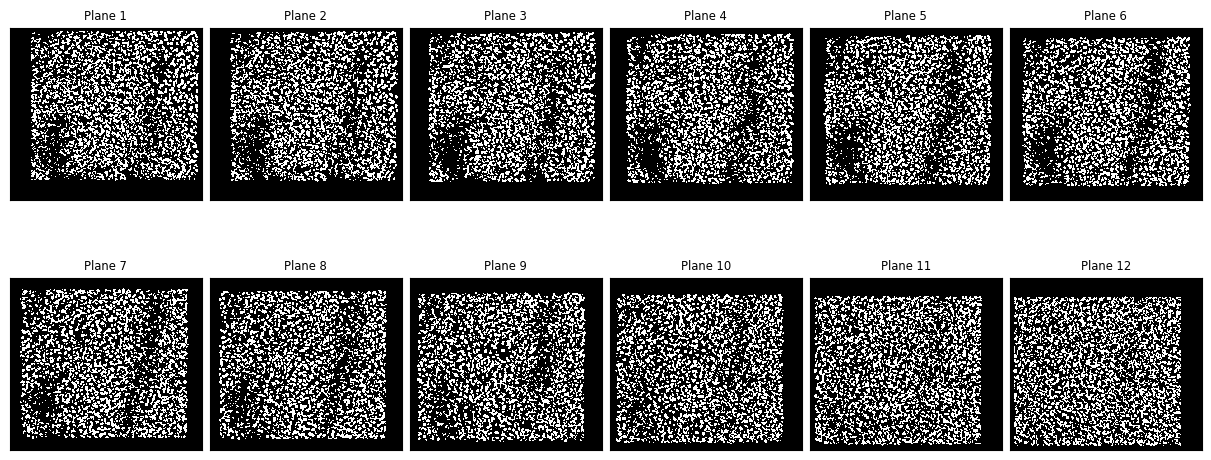

In [42]:
tfu.show_tif_all_planes(vmap, ncols=6, figsize=(12,5), vminmax=(0.0000, 0.000000005001))

In [64]:
%%time
job.params['peak_thresh'] = 1e-5
job.params['detection_timebin'] = 1

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.5

job.params['extend_thresh'] = 0.01
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['patch_size_xy'] = (250, 250)

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=vmap)

      Found dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/segmentation and /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 9
      Found dir /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/segmentation/patch-0000
         Loading 34.23 GB movie to memory, shape: (12252, 12, 250, 250) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.000 and Th2: 5.000
         Iter 0000: running 64 ROIs in parallel


/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 1 at 07, 200, 095, peak: 0.107, thresh: 5.000, 446 frames, 330 pixels
         Added cell 2 at 06, 200, 058, peak: 0.095, thresh: 5.000, 338 frames, 248 pixels
         Added cell 3 at 07, 071, 032, peak: 0.084, thresh: 5.000, 249 frames, 117 pixels
         Added cell 4 at 07, 200, 174, peak: 0.072, thresh: 5.000, 340 frames, 275 pixels
         Added cell 5 at 07, 167, 215, peak: 0.057, thresh: 5.000, 158 frames, 113 pixels
         Added cell 6 at 07, 183, 062, peak: 0.057, thresh: 5.000, 190 frames, 124 pixels
         Added cell 7 at 10, 142, 094, peak: 0.056, thresh: 5.000, 160 frames, 69 pixels
         Added cell 8 at 04, 155, 139, peak: 0.055, thresh: 5.000, 198 frames, 131 pixels
         Added cell 9 at 06, 191, 113, peak: 0.048, thresh: 5.000, 179 frames, 117 pixels
         Added cell 10 at 04, 183, 050, peak: 0.045, thresh: 5.000, 140 frames, 333 pixels
         Added cell 11 at 04, 068, 057, peak: 0.041, thresh: 5.000, 180 frames, 136 pixels
         

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 193 at 07, 180, 168, peak: 0.019, thresh: 5.000, 101 frames, 35 pixels
         Added cell 194 at 04, 175, 152, peak: 0.017, thresh: 5.000, 267 frames, 33 pixels
         Added cell 195 at 04, 167, 064, peak: 0.016, thresh: 5.000, 251 frames, 45 pixels
         Added cell 196 at 10, 177, 084, peak: 0.015, thresh: 5.000, 300 frames, 42 pixels
         Added cell 197 at 08, 081, 162, peak: 0.015, thresh: 5.000, 109 frames, 18 pixels
         Added cell 198 at 05, 069, 165, peak: 0.015, thresh: 5.000, 248 frames, 43 pixels
         Added cell 199 at 09, 178, 103, peak: 0.015, thresh: 5.000, 393 frames, 22 pixels
         Added cell 200 at 04, 180, 136, peak: 0.014, thresh: 5.000, 211 frames, 19 pixels
         Added cell 201 at 07, 198, 081, peak: 0.014, thresh: 5.000, 172 frames, 42 pixels
         Added cell 202 at 05, 191, 187, peak: 0.014, thresh: 5.000, 118 frames, 26 pixels
         Added cell 203 at 07, 063, 141, peak: 0.013, thresh: 5.000, 119 frames, 22 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 257 at 03, 162, 076, peak: 0.014, thresh: 5.000, 148 frames, 21 pixels
         Added cell 258 at 09, 185, 074, peak: 0.013, thresh: 5.000, 236 frames, 26 pixels
         Added cell 259 at 07, 200, 066, peak: 0.013, thresh: 5.000, 200 frames, 18 pixels
         Added cell 260 at 03, 195, 194, peak: 0.013, thresh: 5.000, 164 frames, 15 pixels
         Added cell 261 at 03, 181, 149, peak: 0.013, thresh: 5.000, 130 frames, 36 pixels
         Added cell 262 at 08, 190, 168, peak: 0.012, thresh: 5.000, 172 frames, 31 pixels
         Added cell 263 at 05, 078, 173, peak: 0.012, thresh: 5.000, 175 frames, 27 pixels
         Added cell 264 at 04, 111, 147, peak: 0.012, thresh: 5.000, 120 frames, 26 pixels
         Added cell 265 at 05, 198, 132, peak: 0.012, thresh: 5.000, 122 frames, 24 pixels
         Added cell 266 at 03, 036, 195, peak: 0.012, thresh: 5.000, 130 frames, 25 pixels
         Added cell 267 at 07, 183, 193, peak: 0.011, thresh: 5.000, 305 frames, 20 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 705 at 07, 160, 102, peak: 0.008, thresh: 5.000, 158 frames, 23 pixels
         Added cell 706 at 11, 106, 200, peak: 0.008, thresh: 5.000, 346 frames, 15 pixels
         Added cell 707 at 08, 087, 111, peak: 0.007, thresh: 5.000, 131 frames, 41 pixels
         Added cell 708 at 07, 075, 183, peak: 0.007, thresh: 5.000, 227 frames, 18 pixels
         Added cell 709 at 09, 182, 099, peak: 0.007, thresh: 5.000, 267 frames, 20 pixels
         Added cell 710 at 06, 188, 120, peak: 0.007, thresh: 5.000, 122 frames, 18 pixels
         Added cell 711 at 05, 131, 178, peak: 0.007, thresh: 5.000, 120 frames, 33 pixels
         Added cell 712 at 01, 054, 198, peak: 0.007, thresh: 5.000, 364 frames, 11 pixels
         Added cell 713 at 06, 051, 129, peak: 0.007, thresh: 5.000, 204 frames, 18 pixels
         Added cell 714 at 02, 199, 142, peak: 0.007, thresh: 5.000, 175 frames, 18 pixels
         Added cell 715 at 08, 176, 155, peak: 0.006, thresh: 5.000, 414 frames, 14 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 1 at 02, 055, 308, peak: 0.101, thresh: 5.000, 373 frames, 266 pixels
         Added cell 2 at 07, 136, 306, peak: 0.086, thresh: 5.000, 357 frames, 247 pixels
         Added cell 3 at 09, 092, 346, peak: 0.081, thresh: 5.000, 195 frames, 143 pixels
         Added cell 4 at 01, 079, 367, peak: 0.081, thresh: 5.000, 279 frames, 137 pixels
         Added cell 5 at 03, 095, 327, peak: 0.080, thresh: 5.000, 183 frames, 173 pixels
         Added cell 6 at 02, 022, 361, peak: 0.078, thresh: 5.000, 333 frames, 164 pixels
         Added cell 7 at 06, 187, 232, peak: 0.076, thresh: 5.000, 217 frames, 132 pixels
         Added cell 8 at 01, 062, 336, peak: 0.064, thresh: 5.000, 226 frames, 69 pixels
         Added cell 9 at 00, 115, 353, peak: 0.064, thresh: 5.000, 162 frames, 57 pixels
         Added cell 10 at 03, 138, 310, peak: 0.062, thresh: 5.000, 204 frames, 154 pixels
         Added cell 11 at 06, 108, 252, peak: 0.061, thresh: 5.000, 218 frames, 136 pixels
         A

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 65 at 02, 088, 318, peak: 0.067, thresh: 5.000, 225 frames, 102 pixels
         Added cell 66 at 04, 111, 348, peak: 0.048, thresh: 5.000, 195 frames, 182 pixels
         Added cell 67 at 07, 171, 269, peak: 0.041, thresh: 5.000, 149 frames, 180 pixels
         Added cell 68 at 05, 081, 333, peak: 0.041, thresh: 5.000, 114 frames, 136 pixels
         Added cell 69 at 04, 147, 360, peak: 0.038, thresh: 5.000, 120 frames, 71 pixels
         Added cell 70 at 03, 111, 366, peak: 0.037, thresh: 5.000, 199 frames, 76 pixels
         Added cell 71 at 08, 155, 268, peak: 0.036, thresh: 5.000, 128 frames, 81 pixels
         Added cell 72 at 08, 195, 236, peak: 0.036, thresh: 5.000, 150 frames, 106 pixels
         Added cell 73 at 01, 035, 396, peak: 0.036, thresh: 5.000, 116 frames, 53 pixels
         Added cell 74 at 02, 074, 339, peak: 0.035, thresh: 5.000, 172 frames, 54 pixels
         Added cell 75 at 02, 055, 370, peak: 0.035, thresh: 5.000, 152 frames, 92 pixels
     

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 257 at 03, 081, 345, peak: 0.025, thresh: 5.000, 167 frames, 31 pixels
         Added cell 258 at 02, 100, 347, peak: 0.022, thresh: 5.000, 208 frames, 38 pixels
         Added cell 259 at 06, 101, 321, peak: 0.021, thresh: 5.000, 125 frames, 23 pixels
         Added cell 260 at 06, 159, 346, peak: 0.021, thresh: 5.000, 145 frames, 29 pixels
         Added cell 261 at 04, 064, 356, peak: 0.021, thresh: 5.000, 181 frames, 18 pixels
         Added cell 262 at 07, 106, 291, peak: 0.021, thresh: 5.000, 250 frames, 37 pixels
         Added cell 263 at 06, 117, 355, peak: 0.020, thresh: 5.000, 138 frames, 53 pixels
         Added cell 264 at 04, 122, 283, peak: 0.020, thresh: 5.000, 121 frames, 63 pixels
         Added cell 265 at 08, 137, 297, peak: 0.019, thresh: 5.000, 140 frames, 19 pixels
         Added cell 266 at 05, 057, 335, peak: 0.019, thresh: 5.000, 95 frames, 34 pixels
         Added cell 267 at 07, 064, 381, peak: 0.019, thresh: 5.000, 117 frames, 45 pixels


/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in di

         Added cell 1 at 02, 174, 554, peak: 0.241, thresh: 5.000, 1291 frames, 382 pixels
         Added cell 2 at 03, 121, 565, peak: 0.224, thresh: 5.000, 1112 frames, 282 pixels
         Added cell 3 at 01, 186, 584, peak: 0.210, thresh: 5.000, 725 frames, 495 pixels
         Added cell 4 at 05, 176, 548, peak: 0.204, thresh: 5.000, 932 frames, 347 pixels
         Added cell 5 at 02, 124, 589, peak: 0.171, thresh: 5.000, 468 frames, 540 pixels
         Added cell 6 at 06, 142, 563, peak: 0.147, thresh: 5.000, 627 frames, 454 pixels
         Added cell 7 at 02, 189, 539, peak: 0.144, thresh: 5.000, 405 frames, 386 pixels
         Added cell 8 at 02, 103, 570, peak: 0.129, thresh: 5.000, 558 frames, 202 pixels
         Added cell 9 at 08, 200, 518, peak: 0.128, thresh: 5.000, 646 frames, 190 pixels
         Added cell 10 at 02, 071, 583, peak: 0.128, thresh: 5.000, 375 frames, 351 pixels
         Added cell 11 at 02, 161, 591, peak: 0.126, thresh: 5.000, 360 frames, 678 pixels
      

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 65 at 04, 109, 559, peak: 0.125, thresh: 5.000, 561 frames, 241 pixels
         Added cell 66 at 02, 147, 565, peak: 0.111, thresh: 5.000, 300 frames, 288 pixels
         Added cell 67 at 03, 164, 546, peak: 0.105, thresh: 5.000, 340 frames, 230 pixels
         Added cell 68 at 01, 119, 596, peak: 0.100, thresh: 5.000, 377 frames, 367 pixels
         Added cell 69 at 02, 131, 563, peak: 0.098, thresh: 5.000, 266 frames, 280 pixels
         Added cell 70 at 01, 108, 576, peak: 0.094, thresh: 5.000, 349 frames, 165 pixels
         Added cell 71 at 00, 199, 576, peak: 0.092, thresh: 5.000, 232 frames, 144 pixels
         Added cell 72 at 01, 167, 582, peak: 0.088, thresh: 5.000, 310 frames, 258 pixels
         Added cell 73 at 04, 184, 528, peak: 0.087, thresh: 5.000, 357 frames, 208 pixels
         Added cell 74 at 07, 185, 559, peak: 0.085, thresh: 5.000, 327 frames, 310 pixels
         Added cell 75 at 04, 186, 546, peak: 0.084, thresh: 5.000, 315 frames, 343 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 129 at 02, 096, 573, peak: 0.092, thresh: 5.000, 208 frames, 279 pixels
         Added cell 130 at 03, 189, 568, peak: 0.067, thresh: 5.000, 237 frames, 183 pixels
         Added cell 131 at 04, 113, 569, peak: 0.067, thresh: 5.000, 180 frames, 207 pixels
         Added cell 132 at 00, 048, 561, peak: 0.066, thresh: 5.000, 203 frames, 83 pixels
         Added cell 133 at 04, 161, 568, peak: 0.065, thresh: 5.000, 156 frames, 221 pixels
         Added cell 134 at 02, 100, 550, peak: 0.065, thresh: 5.000, 145 frames, 213 pixels
         Added cell 135 at 03, 027, 540, peak: 0.055, thresh: 5.000, 26 frames, 707 pixels
         Added cell 136 at 00, 062, 602, peak: 0.055, thresh: 5.000, 138 frames, 120 pixels
         Added cell 137 at 00, 136, 588, peak: 0.055, thresh: 5.000, 161 frames, 124 pixels
         Added cell 138 at 05, 070, 568, peak: 0.054, thresh: 5.000, 162 frames, 149 pixels
         Added cell 139 at 02, 145, 520, peak: 0.053, thresh: 5.000, 157 frames, 1

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in di

         Added cell 193 at 04, 086, 572, peak: 0.057, thresh: 5.000, 234 frames, 114 pixels
         Added cell 194 at 01, 050, 571, peak: 0.055, thresh: 4.987, 144 frames, 193 pixels
         Added cell 195 at 07, 074, 557, peak: 0.046, thresh: 5.000, 167 frames, 136 pixels
         Added cell 196 at 02, 197, 523, peak: 0.044, thresh: 5.000, 119 frames, 216 pixels
         Added cell 197 at 03, 112, 547, peak: 0.042, thresh: 5.000, 180 frames, 102 pixels
         Added cell 198 at 06, 044, 548, peak: 0.042, thresh: 5.000, 180 frames, 73 pixels
         Added cell 199 at 01, 059, 587, peak: 0.041, thresh: 5.000, 249 frames, 95 pixels
         Added cell 200 at 00, 181, 502, peak: 0.041, thresh: 5.000, 161 frames, 102 pixels
         Added cell 201 at 00, 078, 552, peak: 0.040, thresh: 5.000, 141 frames, 50 pixels
         Added cell 202 at 02, 179, 519, peak: 0.038, thresh: 5.000, 165 frames, 152 pixels
         Added cell 203 at 02, 090, 421, peak: 0.037, thresh: 5.000, 151 frames, 10

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 257 at 04, 124, 555, peak: 0.036, thresh: 5.000, 168 frames, 81 pixels
         Added cell 258 at 01, 101, 423, peak: 0.035, thresh: 5.000, 135 frames, 51 pixels
         Added cell 259 at 01, 072, 459, peak: 0.034, thresh: 5.000, 217 frames, 69 pixels
         Added cell 260 at 01, 039, 566, peak: 0.033, thresh: 5.000, 114 frames, 107 pixels
         Added cell 261 at 00, 055, 564, peak: 0.033, thresh: 5.000, 140 frames, 44 pixels
         Added cell 262 at 05, 171, 530, peak: 0.032, thresh: 5.000, 195 frames, 126 pixels
         Added cell 263 at 04, 138, 570, peak: 0.031, thresh: 5.000, 196 frames, 32 pixels
         Added cell 264 at 03, 026, 509, peak: 0.031, thresh: 5.000, 182 frames, 59 pixels
         Added cell 265 at 06, 065, 419, peak: 0.029, thresh: 5.000, 118 frames, 94 pixels
         Added cell 266 at 03, 113, 537, peak: 0.028, thresh: 5.000, 126 frames, 72 pixels
         Added cell 267 at 02, 022, 407, peak: 0.028, thresh: 5.000, 141 frames, 523 pix

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 321 at 04, 135, 575, peak: 0.028, thresh: 5.000, 128 frames, 167 pixels
         Added cell 322 at 05, 104, 535, peak: 0.028, thresh: 5.000, 159 frames, 70 pixels
         Added cell 323 at 00, 059, 465, peak: 0.028, thresh: 5.000, 185 frames, 29 pixels
         Added cell 324 at 01, 063, 414, peak: 0.027, thresh: 5.000, 122 frames, 38 pixels
         Added cell 325 at 05, 162, 518, peak: 0.026, thresh: 5.000, 130 frames, 40 pixels
         Added cell 326 at 06, 071, 538, peak: 0.026, thresh: 5.000, 269 frames, 36 pixels
         Added cell 327 at 00, 085, 460, peak: 0.024, thresh: 5.000, 226 frames, 48 pixels
         Added cell 328 at 04, 094, 427, peak: 0.024, thresh: 5.000, 141 frames, 67 pixels
         Added cell 329 at 07, 183, 510, peak: 0.024, thresh: 5.000, 119 frames, 27 pixels
         Added cell 330 at 01, 017, 410, peak: 0.024, thresh: 5.000, 94 frames, 42 pixels
         Added cell 331 at 07, 077, 426, peak: 0.024, thresh: 5.000, 172 frames, 48 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 385 at 06, 161, 524, peak: 0.025, thresh: 5.000, 189 frames, 33 pixels
         Added cell 386 at 05, 127, 574, peak: 0.022, thresh: 5.000, 127 frames, 79 pixels
         Added cell 387 at 04, 093, 532, peak: 0.022, thresh: 5.000, 149 frames, 28 pixels
         Added cell 388 at 02, 075, 400, peak: 0.021, thresh: 5.000, 90 frames, 33 pixels
         Added cell 389 at 08, 188, 522, peak: 0.021, thresh: 5.000, 161 frames, 22 pixels
         Added cell 390 at 05, 048, 537, peak: 0.020, thresh: 5.000, 187 frames, 28 pixels
         Added cell 391 at 03, 101, 408, peak: 0.020, thresh: 5.000, 115 frames, 87 pixels
         Added cell 392 at 00, 026, 432, peak: 0.019, thresh: 5.000, 156 frames, 24 pixels
         Added cell 393 at 05, 066, 532, peak: 0.018, thresh: 5.000, 187 frames, 32 pixels
         Added cell 394 at 01, 018, 402, peak: 0.018, thresh: 5.000, 120 frames, 13 pixels
         Added cell 395 at 08, 060, 517, peak: 0.018, thresh: 5.000, 104 frames, 82 pixels


/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 513 at 07, 136, 535, peak: 0.015, thresh: 5.000, 124 frames, 53 pixels
         Added cell 514 at 01, 103, 400, peak: 0.015, thresh: 5.000, 140 frames, 12 pixels
         Added cell 515 at 04, 125, 523, peak: 0.015, thresh: 5.000, 105 frames, 22 pixels
         Added cell 516 at 06, 086, 514, peak: 0.014, thresh: 5.000, 168 frames, 19 pixels
         Added cell 517 at 03, 029, 422, peak: 0.014, thresh: 5.000, 88 frames, 14 pixels
         Added cell 518 at 09, 079, 530, peak: 0.014, thresh: 5.000, 355 frames, 21 pixels
         Added cell 519 at 10, 141, 523, peak: 0.014, thresh: 5.000, 203 frames, 20 pixels
         Added cell 520 at 07, 048, 512, peak: 0.014, thresh: 5.000, 155 frames, 21 pixels
         Added cell 521 at 09, 200, 527, peak: 0.014, thresh: 5.000, 360 frames, 34 pixels
         Added cell 522 at 09, 103, 544, peak: 0.014, thresh: 5.000, 314 frames, 33 pixels
         Added cell 523 at 02, 196, 416, peak: 0.014, thresh: 5.000, 432 frames, 28 pixels


/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 577 at 07, 148, 533, peak: 0.015, thresh: 5.000, 149 frames, 16 pixels
         Added cell 578 at 01, 033, 426, peak: 0.014, thresh: 5.000, 137 frames, 15 pixels
         Added cell 579 at 06, 129, 527, peak: 0.014, thresh: 5.000, 262 frames, 20 pixels
         Added cell 580 at 00, 098, 407, peak: 0.014, thresh: 5.000, 129 frames, 16 pixels
         Added cell 581 at 06, 099, 515, peak: 0.014, thresh: 5.000, 138 frames, 22 pixels
         Added cell 582 at 07, 176, 512, peak: 0.013, thresh: 5.000, 201 frames, 65 pixels
         Added cell 583 at 11, 071, 524, peak: 0.013, thresh: 5.000, 353 frames, 16 pixels
         Added cell 584 at 08, 070, 522, peak: 0.013, thresh: 5.000, 251 frames, 11 pixels
         Added cell 585 at 11, 087, 525, peak: 0.013, thresh: 5.000, 163 frames, 12 pixels
         Added cell 586 at 09, 105, 511, peak: 0.013, thresh: 5.000, 291 frames, 15 pixels
         Added cell 587 at 02, 082, 526, peak: 0.013, thresh: 5.000, 248 frames, 22 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 641 at 00, 046, 427, peak: 0.013, thresh: 5.000, 248 frames, 13 pixels
         Added cell 642 at 07, 115, 537, peak: 0.012, thresh: 5.000, 223 frames, 22 pixels
         Added cell 643 at 07, 173, 506, peak: 0.012, thresh: 5.000, 193 frames, 23 pixels
         Added cell 644 at 00, 089, 408, peak: 0.012, thresh: 5.000, 207 frames, 20 pixels
         Added cell 645 at 00, 044, 452, peak: 0.012, thresh: 5.000, 225 frames, 17 pixels
         Added cell 646 at 08, 112, 512, peak: 0.012, thresh: 5.000, 134 frames, 38 pixels
         Added cell 647 at 01, 080, 458, peak: 0.012, thresh: 5.000, 128 frames, 13 pixels
         Added cell 648 at 09, 184, 486, peak: 0.011, thresh: 5.000, 188 frames, 11 pixels
         Added cell 649 at 08, 131, 523, peak: 0.011, thresh: 5.000, 108 frames, 18 pixels
         Added cell 650 at 11, 092, 528, peak: 0.011, thresh: 5.000, 333 frames, 25 pixels
         Added cell 651 at 11, 110, 518, peak: 0.011, thresh: 5.000, 370 frames, 13 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 833 at 10, 170, 483, peak: 0.009, thresh: 5.000, 334 frames, 15 pixels
         Added cell 834 at 09, 188, 482, peak: 0.009, thresh: 5.000, 430 frames, 16 pixels
         Added cell 835 at 11, 172, 461, peak: 0.009, thresh: 5.000, 245 frames, 11 pixels
         Added cell 836 at 08, 121, 518, peak: 0.009, thresh: 5.000, 215 frames, 17 pixels
         Added cell 837 at 09, 078, 473, peak: 0.009, thresh: 5.000, 359 frames, 22 pixels
         Added cell 838 at 11, 126, 495, peak: 0.008, thresh: 5.000, 193 frames, 13 pixels
         Added cell 839 at 11, 200, 498, peak: 0.008, thresh: 5.000, 272 frames, 11 pixels
         Added cell 840 at 10, 110, 495, peak: 0.008, thresh: 5.000, 331 frames, 20 pixels
         Added cell 841 at 11, 165, 498, peak: 0.008, thresh: 5.000, 269 frames, 25 pixels
         Added cell 842 at 01, 141, 451, peak: 0.008, thresh: 5.000, 333 frames, 22 pixels
         Added cell 843 at 09, 147, 500, peak: 0.008, thresh: 5.000, 232 frames, 32 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 897 at 11, 165, 467, peak: 0.009, thresh: 5.000, 360 frames, 19 pixels
         Added cell 898 at 11, 183, 492, peak: 0.009, thresh: 5.000, 322 frames, 10 pixels
         Added cell 899 at 10, 145, 495, peak: 0.008, thresh: 5.000, 424 frames, 23 pixels
         Added cell 900 at 11, 165, 531, peak: 0.008, thresh: 5.000, 303 frames, 14 pixels
         Added cell 901 at 02, 125, 402, peak: 0.007, thresh: 5.000, 143 frames, 10 pixels
         Added cell 902 at 11, 119, 483, peak: 0.007, thresh: 5.000, 304 frames, 15 pixels
         Added cell 903 at 08, 194, 481, peak: 0.007, thresh: 5.000, 290 frames, 35 pixels
         Added cell 904 at 00, 160, 403, peak: 0.007, thresh: 5.000, 248 frames, 49 pixels
         Added cell 905 at 09, 099, 420, peak: 0.007, thresh: 5.000, 233 frames, 22 pixels
         Added cell 906 at 09, 182, 454, peak: 0.007, thresh: 5.000, 356 frames, 17 pixels
         Added cell 907 at 05, 094, 513, peak: 0.007, thresh: 5.000, 201 frames, 24 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 1 at 08, 240, 036, peak: 0.216, thresh: 5.000, 688 frames, 426 pixels
         Added cell 2 at 06, 266, 053, peak: 0.211, thresh: 5.000, 542 frames, 398 pixels
         Added cell 3 at 07, 313, 054, peak: 0.204, thresh: 5.000, 671 frames, 434 pixels
         Added cell 4 at 04, 338, 083, peak: 0.139, thresh: 5.000, 735 frames, 376 pixels
         Added cell 5 at 09, 268, 157, peak: 0.135, thresh: 5.000, 511 frames, 321 pixels
         Added cell 6 at 08, 224, 044, peak: 0.128, thresh: 5.000, 512 frames, 273 pixels
         Added cell 7 at 07, 286, 061, peak: 0.126, thresh: 5.000, 441 frames, 345 pixels
         Added cell 8 at 06, 244, 132, peak: 0.110, thresh: 5.000, 430 frames, 306 pixels
         Added cell 9 at 08, 348, 184, peak: 0.109, thresh: 5.000, 408 frames, 313 pixels
         Added cell 10 at 07, 202, 174, peak: 0.105, thresh: 5.000, 426 frames, 386 pixels
         Added cell 11 at 07, 201, 095, peak: 0.102, thresh: 5.000, 454 frames, 308 pixels
        

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 129 at 05, 258, 065, peak: 0.040, thresh: 4.861, 128 frames, 59 pixels
         Added cell 130 at 06, 337, 215, peak: 0.037, thresh: 5.000, 209 frames, 143 pixels
         Added cell 131 at 06, 225, 052, peak: 0.032, thresh: 5.000, 130 frames, 128 pixels
         Added cell 132 at 04, 303, 051, peak: 0.030, thresh: 5.000, 87 frames, 552 pixels
         Added cell 133 at 05, 328, 056, peak: 0.027, thresh: 5.000, 84 frames, 296 pixels
         Added cell 134 at 05, 208, 058, peak: 0.027, thresh: 5.000, 170 frames, 39 pixels
         Added cell 135 at 02, 263, 067, peak: 0.026, thresh: 5.000, 114 frames, 47 pixels
         Added cell 136 at 08, 221, 030, peak: 0.026, thresh: 5.000, 208 frames, 39 pixels
         Added cell 137 at 08, 329, 032, peak: 0.026, thresh: 5.000, 105 frames, 73 pixels
         Added cell 138 at 02, 281, 066, peak: 0.024, thresh: 5.000, 90 frames, 37 pixels
         Added cell 139 at 05, 352, 214, peak: 0.023, thresh: 5.000, 77 frames, 30 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 193 at 04, 218, 056, peak: 0.026, thresh: 5.000, 105 frames, 78 pixels
         Added cell 194 at 04, 304, 058, peak: 0.026, thresh: 5.000, 249 frames, 29 pixels
         Added cell 195 at 05, 338, 044, peak: 0.024, thresh: 5.000, 107 frames, 45 pixels
         Added cell 196 at 03, 289, 074, peak: 0.022, thresh: 5.000, 131 frames, 42 pixels
         Added cell 197 at 07, 209, 040, peak: 0.022, thresh: 5.000, 161 frames, 15 pixels
         Added cell 198 at 03, 304, 077, peak: 0.021, thresh: 5.000, 100 frames, 53 pixels
         Added cell 199 at 08, 270, 072, peak: 0.020, thresh: 5.000, 118 frames, 39 pixels
         Added cell 200 at 08, 294, 043, peak: 0.020, thresh: 5.000, 147 frames, 16 pixels
         Added cell 201 at 07, 202, 068, peak: 0.020, thresh: 5.000, 254 frames, 40 pixels
         Added cell 202 at 07, 218, 120, peak: 0.019, thresh: 5.000, 116 frames, 27 pixels
         Added cell 203 at 05, 268, 066, peak: 0.019, thresh: 5.000, 82 frames, 60 pixels


/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 257 at 06, 214, 059, peak: 0.020, thresh: 5.000, 178 frames, 30 pixels
         Added cell 258 at 04, 304, 066, peak: 0.019, thresh: 5.000, 152 frames, 23 pixels
         Added cell 259 at 05, 296, 046, peak: 0.019, thresh: 5.000, 138 frames, 10 pixels
         Added cell 260 at 07, 316, 214, peak: 0.019, thresh: 5.000, 143 frames, 33 pixels
         Added cell 261 at 04, 286, 080, peak: 0.018, thresh: 5.000, 217 frames, 13 pixels
         Added cell 262 at 05, 244, 061, peak: 0.016, thresh: 5.000, 166 frames, 56 pixels
         Added cell 263 at 05, 224, 151, peak: 0.016, thresh: 5.000, 140 frames, 24 pixels
         Added cell 264 at 07, 322, 034, peak: 0.016, thresh: 5.000, 162 frames, 30 pixels
         Added cell 265 at 07, 201, 136, peak: 0.015, thresh: 5.000, 139 frames, 28 pixels
         Added cell 266 at 11, 327, 041, peak: 0.015, thresh: 5.000, 325 frames, 21 pixels
         Added cell 267 at 08, 302, 047, peak: 0.015, thresh: 5.000, 230 frames, 33 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 449 at 07, 285, 037, peak: 0.013, thresh: 5.000, 112 frames, 40 pixels
         Added cell 450 at 04, 211, 153, peak: 0.013, thresh: 5.000, 160 frames, 23 pixels
         Added cell 451 at 04, 237, 167, peak: 0.013, thresh: 5.000, 104 frames, 34 pixels
         Added cell 452 at 08, 289, 203, peak: 0.012, thresh: 5.000, 451 frames, 27 pixels
         Added cell 453 at 10, 246, 098, peak: 0.011, thresh: 5.000, 342 frames, 16 pixels
         Added cell 454 at 10, 342, 180, peak: 0.011, thresh: 5.000, 358 frames, 17 pixels
         Added cell 455 at 05, 238, 215, peak: 0.011, thresh: 5.000, 140 frames, 14 pixels
         Added cell 456 at 11, 248, 193, peak: 0.011, thresh: 5.000, 250 frames, 23 pixels
         Added cell 457 at 08, 256, 127, peak: 0.011, thresh: 5.000, 234 frames, 30 pixels
         Added cell 458 at 04, 232, 193, peak: 0.010, thresh: 5.000, 182 frames, 18 pixels
         Added cell 459 at 02, 301, 084, peak: 0.010, thresh: 5.000, 179 frames, 19 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 1 at 02, 220, 584, peak: 0.152, thresh: 5.000, 406 frames, 553 pixels
         Added cell 2 at 04, 249, 577, peak: 0.142, thresh: 5.000, 612 frames, 540 pixels
         Added cell 3 at 08, 201, 518, peak: 0.136, thresh: 5.000, 650 frames, 194 pixels
         Added cell 4 at 08, 287, 512, peak: 0.134, thresh: 5.000, 556 frames, 420 pixels
         Added cell 5 at 00, 226, 547, peak: 0.128, thresh: 5.000, 389 frames, 292 pixels
         Added cell 6 at 04, 212, 554, peak: 0.107, thresh: 5.000, 354 frames, 281 pixels
         Added cell 7 at 05, 241, 551, peak: 0.105, thresh: 5.000, 404 frames, 271 pixels
         Added cell 8 at 03, 214, 531, peak: 0.100, thresh: 5.000, 328 frames, 307 pixels
         Added cell 9 at 07, 260, 506, peak: 0.089, thresh: 5.000, 351 frames, 251 pixels
         Added cell 10 at 05, 258, 554, peak: 0.086, thresh: 5.000, 306 frames, 211 pixels
         Added cell 11 at 08, 204, 557, peak: 0.083, thresh: 5.000, 322 frames, 166 pixels
        

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 65 at 00, 230, 576, peak: 0.107, thresh: 5.000, 304 frames, 600 pixels
         Added cell 66 at 03, 231, 575, peak: 0.088, thresh: 5.000, 276 frames, 306 pixels
         Added cell 67 at 02, 235, 559, peak: 0.086, thresh: 5.000, 348 frames, 197 pixels
         Added cell 68 at 02, 214, 578, peak: 0.075, thresh: 5.000, 259 frames, 188 pixels
         Added cell 69 at 01, 219, 551, peak: 0.072, thresh: 5.000, 211 frames, 153 pixels
         Added cell 70 at 05, 207, 565, peak: 0.065, thresh: 5.000, 180 frames, 146 pixels
         Added cell 71 at 01, 228, 535, peak: 0.065, thresh: 5.000, 250 frames, 126 pixels
         Added cell 72 at 05, 246, 545, peak: 0.062, thresh: 5.000, 272 frames, 223 pixels
         Added cell 73 at 02, 257, 588, peak: 0.060, thresh: 5.000, 178 frames, 153 pixels
         Added cell 74 at 09, 255, 518, peak: 0.059, thresh: 5.000, 227 frames, 159 pixels
         Added cell 75 at 04, 226, 539, peak: 0.055, thresh: 5.000, 186 frames, 159 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 129 at 03, 240, 574, peak: 0.082, thresh: 5.000, 220 frames, 253 pixels
         Added cell 130 at 01, 224, 559, peak: 0.072, thresh: 5.000, 276 frames, 207 pixels
         Added cell 131 at 00, 250, 598, peak: 0.050, thresh: 5.000, 47 frames, 620 pixels
         Added cell 132 at 03, 236, 524, peak: 0.046, thresh: 5.000, 188 frames, 174 pixels
         Added cell 133 at 03, 210, 582, peak: 0.042, thresh: 5.000, 127 frames, 70 pixels
         Added cell 134 at 00, 241, 575, peak: 0.041, thresh: 5.000, 213 frames, 58 pixels
         Added cell 135 at 04, 222, 564, peak: 0.039, thresh: 5.000, 185 frames, 126 pixels
         Added cell 136 at 07, 256, 545, peak: 0.038, thresh: 5.000, 141 frames, 88 pixels
         Added cell 137 at 00, 280, 588, peak: 0.035, thresh: 5.000, 135 frames, 44 pixels
         Added cell 138 at 00, 214, 539, peak: 0.033, thresh: 5.000, 278 frames, 32 pixels
         Added cell 139 at 05, 254, 522, peak: 0.029, thresh: 5.000, 149 frames, 95 pi

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 193 at 00, 216, 565, peak: 0.051, thresh: 5.000, 134 frames, 75 pixels
         Added cell 194 at 03, 212, 569, peak: 0.043, thresh: 5.000, 228 frames, 270 pixels
         Added cell 195 at 00, 235, 551, peak: 0.033, thresh: 5.000, 148 frames, 36 pixels
         Added cell 196 at 03, 245, 521, peak: 0.030, thresh: 5.000, 230 frames, 48 pixels
         Added cell 197 at 00, 227, 587, peak: 0.027, thresh: 5.000, 148 frames, 20 pixels
         Added cell 198 at 00, 263, 566, peak: 0.025, thresh: 5.000, 364 frames, 26 pixels
         Added cell 199 at 04, 273, 558, peak: 0.024, thresh: 5.000, 154 frames, 69 pixels
         Added cell 200 at 06, 252, 537, peak: 0.023, thresh: 5.000, 112 frames, 69 pixels
         Added cell 201 at 04, 231, 554, peak: 0.022, thresh: 5.000, 144 frames, 28 pixels
         Added cell 202 at 00, 261, 550, peak: 0.021, thresh: 5.000, 142 frames, 32 pixels
         Added cell 203 at 00, 270, 527, peak: 0.020, thresh: 5.000, 182 frames, 21 pixel

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 257 at 03, 215, 561, peak: 0.038, thresh: 5.000, 111 frames, 58 pixels
         Added cell 258 at 01, 259, 576, peak: 0.025, thresh: 5.000, 232 frames, 48 pixels
         Added cell 259 at 07, 264, 522, peak: 0.022, thresh: 5.000, 116 frames, 44 pixels
         Added cell 260 at 00, 246, 560, peak: 0.022, thresh: 5.000, 108 frames, 14 pixels
         Added cell 261 at 02, 221, 594, peak: 0.021, thresh: 5.000, 146 frames, 129 pixels
         Added cell 262 at 00, 268, 534, peak: 0.019, thresh: 5.000, 205 frames, 17 pixels
         Added cell 263 at 07, 251, 550, peak: 0.018, thresh: 5.000, 112 frames, 14 pixels
         Added cell 264 at 02, 233, 508, peak: 0.018, thresh: 5.000, 145 frames, 46 pixels
         Added cell 265 at 05, 284, 561, peak: 0.018, thresh: 5.000, 177 frames, 40 pixels
         Added cell 266 at 06, 229, 546, peak: 0.018, thresh: 5.000, 221 frames, 26 pixels
         Added cell 267 at 02, 267, 549, peak: 0.016, thresh: 5.000, 110 frames, 38 pixel

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 321 at 03, 268, 562, peak: 0.021, thresh: 5.000, 127 frames, 58 pixels
         Added cell 322 at 07, 271, 512, peak: 0.017, thresh: 5.000, 260 frames, 22 pixels
         Added cell 323 at 08, 265, 535, peak: 0.015, thresh: 5.000, 202 frames, 28 pixels
         Added cell 324 at 05, 251, 513, peak: 0.015, thresh: 5.000, 233 frames, 33 pixels
         Added cell 325 at 09, 246, 526, peak: 0.014, thresh: 5.000, 174 frames, 19 pixels
         Added cell 326 at 05, 243, 528, peak: 0.014, thresh: 5.000, 197 frames, 37 pixels
         Added cell 327 at 09, 255, 497, peak: 0.013, thresh: 5.000, 345 frames, 31 pixels
         Added cell 328 at 00, 284, 548, peak: 0.013, thresh: 5.000, 132 frames, 12 pixels
         Added cell 329 at 04, 290, 553, peak: 0.013, thresh: 5.000, 137 frames, 10 pixels
         Added cell 330 at 06, 211, 545, peak: 0.013, thresh: 5.000, 241 frames, 30 pixels
         Added cell 331 at 04, 335, 509, peak: 0.012, thresh: 5.000, 115 frames, 23 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 1 at 08, 432, 204, peak: 0.187, thresh: 5.000, 848 frames, 320 pixels
         Added cell 2 at 08, 363, 215, peak: 0.150, thresh: 5.000, 773 frames, 518 pixels
         Added cell 3 at 07, 386, 215, peak: 0.143, thresh: 5.000, 454 frames, 307 pixels
         Added cell 4 at 09, 442, 177, peak: 0.142, thresh: 5.000, 588 frames, 261 pixels
         Added cell 5 at 07, 515, 073, peak: 0.138, thresh: 5.000, 622 frames, 225 pixels
         Added cell 6 at 08, 418, 179, peak: 0.133, thresh: 5.000, 554 frames, 391 pixels
         Added cell 7 at 08, 466, 192, peak: 0.089, thresh: 5.000, 353 frames, 263 pixels
         Added cell 8 at 07, 482, 189, peak: 0.087, thresh: 5.000, 329 frames, 314 pixels
         Added cell 9 at 05, 392, 184, peak: 0.085, thresh: 5.000, 395 frames, 441 pixels
         Added cell 10 at 11, 529, 049, peak: 0.076, thresh: 5.000, 293 frames, 102 pixels
         Added cell 11 at 08, 473, 046, peak: 0.066, thresh: 5.000, 231 frames, 200 pixels
        

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 65 at 10, 450, 184, peak: 0.092, thresh: 5.000, 245 frames, 151 pixels
         Added cell 66 at 09, 428, 194, peak: 0.038, thresh: 5.000, 146 frames, 64 pixels
         Added cell 67 at 07, 396, 200, peak: 0.037, thresh: 5.000, 188 frames, 52 pixels
         Added cell 68 at 09, 369, 038, peak: 0.030, thresh: 5.000, 209 frames, 59 pixels
         Added cell 69 at 08, 353, 176, peak: 0.027, thresh: 5.000, 231 frames, 28 pixels
         Added cell 70 at 09, 484, 044, peak: 0.025, thresh: 5.000, 123 frames, 53 pixels
         Added cell 71 at 09, 387, 182, peak: 0.023, thresh: 5.000, 311 frames, 43 pixels
         Added cell 72 at 05, 353, 214, peak: 0.022, thresh: 5.000, 125 frames, 22 pixels
         Added cell 73 at 07, 370, 196, peak: 0.021, thresh: 5.000, 307 frames, 33 pixels
         Added cell 74 at 07, 411, 211, peak: 0.021, thresh: 5.000, 199 frames, 51 pixels
         Added cell 75 at 04, 371, 188, peak: 0.020, thresh: 5.000, 190 frames, 32 pixels
         

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 129 at 09, 392, 209, peak: 0.026, thresh: 5.000, 136 frames, 69 pixels
         Added cell 130 at 11, 437, 171, peak: 0.024, thresh: 5.000, 312 frames, 34 pixels
         Added cell 131 at 06, 385, 196, peak: 0.024, thresh: 5.000, 91 frames, 73 pixels
         Added cell 132 at 06, 353, 208, peak: 0.019, thresh: 5.000, 280 frames, 35 pixels
         Added cell 133 at 09, 388, 192, peak: 0.018, thresh: 5.000, 376 frames, 28 pixels
         Added cell 134 at 06, 394, 211, peak: 0.017, thresh: 5.000, 127 frames, 32 pixels
         Added cell 135 at 06, 417, 199, peak: 0.017, thresh: 5.000, 138 frames, 24 pixels
         Added cell 136 at 08, 441, 204, peak: 0.017, thresh: 5.000, 226 frames, 15 pixels
         Added cell 137 at 03, 376, 213, peak: 0.016, thresh: 5.000, 207 frames, 20 pixels
         Added cell 138 at 07, 434, 185, peak: 0.015, thresh: 5.000, 229 frames, 38 pixels
         Added cell 139 at 04, 421, 215, peak: 0.015, thresh: 5.000, 185 frames, 28 pixels


/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 257 at 07, 385, 203, peak: 0.016, thresh: 5.000, 250 frames, 45 pixels
         Added cell 258 at 07, 435, 196, peak: 0.012, thresh: 5.000, 117 frames, 13 pixels
         Added cell 259 at 11, 432, 159, peak: 0.012, thresh: 5.000, 293 frames, 13 pixels
         Added cell 260 at 08, 407, 190, peak: 0.012, thresh: 5.000, 172 frames, 26 pixels
         Added cell 261 at 08, 371, 165, peak: 0.012, thresh: 5.000, 187 frames, 15 pixels
         Added cell 262 at 09, 468, 160, peak: 0.012, thresh: 5.000, 131 frames, 14 pixels
         Added cell 263 at 10, 393, 174, peak: 0.012, thresh: 5.000, 217 frames, 16 pixels
         Added cell 264 at 08, 425, 215, peak: 0.012, thresh: 5.000, 166 frames, 12 pixels
         Added cell 265 at 03, 418, 211, peak: 0.011, thresh: 5.000, 186 frames, 16 pixels
         Added cell 266 at 11, 381, 189, peak: 0.011, thresh: 5.000, 340 frames, 13 pixels
         Added cell 267 at 05, 455, 203, peak: 0.011, thresh: 5.000, 104 frames, 22 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 385 at 06, 403, 200, peak: 0.012, thresh: 5.000, 221 frames, 23 pixels
         Added cell 386 at 09, 391, 202, peak: 0.012, thresh: 5.000, 268 frames, 29 pixels
         Added cell 387 at 11, 389, 177, peak: 0.010, thresh: 5.000, 221 frames, 14 pixels
         Added cell 388 at 06, 441, 187, peak: 0.010, thresh: 5.000, 147 frames, 32 pixels
         Added cell 389 at 09, 419, 210, peak: 0.009, thresh: 5.000, 188 frames, 17 pixels
         Added cell 390 at 10, 465, 152, peak: 0.009, thresh: 5.000, 353 frames, 10 pixels
         Added cell 391 at 07, 422, 190, peak: 0.009, thresh: 5.000, 181 frames, 19 pixels
         Added cell 392 at 09, 457, 207, peak: 0.009, thresh: 5.000, 287 frames, 17 pixels
         Added cell 393 at 06, 451, 209, peak: 0.009, thresh: 5.000, 106 frames, 37 pixels
         Added cell 394 at 04, 376, 197, peak: 0.009, thresh: 5.000, 147 frames, 23 pixels
         Added cell 395 at 11, 482, 022, peak: 0.009, thresh: 5.000, 316 frames, 22 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 577 at 07, 367, 163, peak: 0.007, thresh: 5.000, 255 frames, 31 pixels
         Added cell 578 at 10, 384, 204, peak: 0.006, thresh: 5.000, 239 frames, 17 pixels
         Added cell 579 at 09, 400, 188, peak: 0.006, thresh: 5.000, 311 frames, 27 pixels
         Added cell 580 at 06, 512, 084, peak: 0.006, thresh: 5.000, 120 frames, 20 pixels
         Added cell 581 at 11, 494, 038, peak: 0.006, thresh: 5.000, 292 frames, 16 pixels
         Added cell 582 at 05, 499, 213, peak: 0.006, thresh: 5.000, 206 frames, 21 pixels
         Added cell 583 at 04, 415, 165, peak: 0.006, thresh: 5.000, 225 frames, 14 pixels
         Added cell 584 at 10, 488, 152, peak: 0.006, thresh: 5.000, 247 frames, 17 pixels
         Added cell 585 at 09, 396, 171, peak: 0.006, thresh: 5.000, 343 frames, 19 pixels
         Added cell 586 at 03, 494, 102, peak: 0.006, thresh: 5.000, 157 frames, 70 pixels
         Added cell 587 at 05, 506, 186, peak: 0.006, thresh: 5.000, 161 frames, 20 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 641 at 11, 394, 205, peak: 0.006, thresh: 5.000, 217 frames, 15 pixels
         Added cell 642 at 11, 388, 031, peak: 0.006, thresh: 5.000, 253 frames, 13 pixels
         Added cell 643 at 10, 404, 034, peak: 0.006, thresh: 5.000, 245 frames, 18 pixels
         Added cell 644 at 00, 466, 086, peak: 0.006, thresh: 5.000, 330 frames, 17 pixels
         Added cell 645 at 04, 469, 103, peak: 0.006, thresh: 5.000, 113 frames, 31 pixels
         Added cell 646 at 09, 456, 128, peak: 0.006, thresh: 5.000, 294 frames, 22 pixels
         Added cell 647 at 04, 495, 109, peak: 0.006, thresh: 5.000, 150 frames, 22 pixels
         Added cell 648 at 10, 472, 199, peak: 0.006, thresh: 5.000, 404 frames, 10 pixels
         Added cell 649 at 09, 457, 147, peak: 0.006, thresh: 5.000, 368 frames, 19 pixels
         Added cell 650 at 08, 477, 148, peak: 0.006, thresh: 5.000, 355 frames, 30 pixels
         Added cell 651 at 04, 491, 214, peak: 0.006, thresh: 5.000, 183 frames, 16 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 641 at 00, 433, 315, peak: 0.012, thresh: 5.000, 296 frames, 13 pixels
         Added cell 642 at 02, 409, 292, peak: 0.012, thresh: 5.000, 163 frames, 21 pixels
         Added cell 643 at 02, 392, 292, peak: 0.012, thresh: 5.000, 140 frames, 30 pixels
         Added cell 644 at 07, 445, 280, peak: 0.012, thresh: 5.000, 189 frames, 20 pixels
         Added cell 645 at 04, 408, 316, peak: 0.011, thresh: 5.000, 145 frames, 26 pixels
         Added cell 646 at 09, 460, 311, peak: 0.011, thresh: 5.000, 204 frames, 27 pixels
         Added cell 647 at 03, 414, 357, peak: 0.011, thresh: 5.000, 158 frames, 19 pixels
         Added cell 648 at 02, 436, 289, peak: 0.011, thresh: 5.000, 133 frames, 39 pixels
         Added cell 649 at 04, 368, 266, peak: 0.011, thresh: 5.000, 171 frames, 24 pixels
         Added cell 650 at 04, 498, 284, peak: 0.011, thresh: 5.000, 50 frames, 523 pixels
         Added cell 651 at 09, 476, 276, peak: 0.011, thresh: 5.000, 446 frames, 25 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 833 at 00, 376, 269, peak: 0.009, thresh: 5.000, 301 frames, 15 pixels
         Added cell 834 at 07, 434, 236, peak: 0.009, thresh: 5.000, 189 frames, 15 pixels
         Added cell 835 at 06, 481, 286, peak: 0.009, thresh: 5.000, 252 frames, 24 pixels
         Added cell 836 at 02, 450, 294, peak: 0.009, thresh: 5.000, 142 frames, 27 pixels
         Added cell 837 at 00, 378, 296, peak: 0.009, thresh: 5.000, 164 frames, 17 pixels
         Added cell 838 at 10, 383, 324, peak: 0.009, thresh: 5.000, 186 frames, 22 pixels
         Added cell 839 at 03, 457, 245, peak: 0.009, thresh: 5.000, 117 frames, 22 pixels
         Added cell 840 at 07, 424, 302, peak: 0.009, thresh: 5.000, 148 frames, 16 pixels
         Added cell 841 at 11, 403, 227, peak: 0.009, thresh: 5.000, 330 frames, 14 pixels
         Added cell 842 at 09, 483, 308, peak: 0.009, thresh: 5.000, 194 frames, 12 pixels
         Added cell 843 at 00, 401, 328, peak: 0.009, thresh: 5.000, 252 frames, 14 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 1 at 08, 525, 500, peak: 0.073, thresh: 5.000, 340 frames, 142 pixels
         Added cell 2 at 03, 467, 567, peak: 0.070, thresh: 5.000, 280 frames, 93 pixels
         Added cell 3 at 03, 482, 497, peak: 0.070, thresh: 5.000, 309 frames, 109 pixels
         Added cell 4 at 02, 402, 492, peak: 0.052, thresh: 5.000, 195 frames, 100 pixels
         Added cell 5 at 04, 490, 464, peak: 0.051, thresh: 5.000, 200 frames, 92 pixels
         Added cell 6 at 02, 427, 586, peak: 0.049, thresh: 5.000, 150 frames, 36 pixels
         Added cell 7 at 02, 382, 590, peak: 0.049, thresh: 5.000, 152 frames, 253 pixels
         Added cell 8 at 04, 357, 510, peak: 0.047, thresh: 5.000, 150 frames, 94 pixels
         Added cell 9 at 03, 425, 507, peak: 0.046, thresh: 5.000, 196 frames, 65 pixels
         Added cell 10 at 00, 399, 602, peak: 0.043, thresh: 5.000, 224 frames, 79 pixels
         Added cell 11 at 11, 491, 528, peak: 0.043, thresh: 5.000, 247 frames, 63 pixels
         Added 

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 129 at 01, 370, 595, peak: 0.033, thresh: 5.000, 88 frames, 423 pixels
         Added cell 130 at 03, 378, 577, peak: 0.027, thresh: 5.000, 230 frames, 57 pixels
         Added cell 131 at 04, 476, 516, peak: 0.023, thresh: 5.000, 210 frames, 69 pixels
         Added cell 132 at 00, 431, 588, peak: 0.020, thresh: 5.000, 123 frames, 23 pixels
         Added cell 133 at 04, 474, 458, peak: 0.019, thresh: 5.000, 103 frames, 16 pixels
         Added cell 134 at 00, 407, 593, peak: 0.018, thresh: 5.000, 115 frames, 25 pixels
         Added cell 135 at 03, 395, 496, peak: 0.018, thresh: 5.000, 132 frames, 28 pixels
         Added cell 136 at 06, 508, 479, peak: 0.017, thresh: 5.000, 179 frames, 25 pixels
         Added cell 137 at 08, 377, 500, peak: 0.017, thresh: 5.000, 351 frames, 61 pixels
         Added cell 138 at 07, 493, 540, peak: 0.017, thresh: 5.000, 145 frames, 28 pixels
         Added cell 139 at 00, 354, 584, peak: 0.016, thresh: 5.000, 247 frames, 13 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms
/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 321 at 02, 447, 562, peak: 0.012, thresh: 5.000, 176 frames, 19 pixels
         Added cell 322 at 05, 483, 469, peak: 0.012, thresh: 5.000, 119 frames, 13 pixels
         Added cell 323 at 07, 489, 453, peak: 0.012, thresh: 5.000, 170 frames, 43 pixels
         Added cell 324 at 02, 392, 572, peak: 0.012, thresh: 5.000, 150 frames, 30 pixels
         Added cell 325 at 06, 498, 477, peak: 0.011, thresh: 5.000, 249 frames, 18 pixels
         Added cell 326 at 04, 419, 543, peak: 0.011, thresh: 5.000, 342 frames, 22 pixels
         Added cell 327 at 03, 453, 497, peak: 0.011, thresh: 5.000, 289 frames, 23 pixels
         Added cell 328 at 08, 397, 499, peak: 0.011, thresh: 5.000, 129 frames, 14 pixels
         Added cell 329 at 02, 468, 467, peak: 0.011, thresh: 5.000, 153 frames, 28 pixels
         Added cell 330 at 06, 399, 545, peak: 0.011, thresh: 5.000, 308 frames, 23 pixels
         Added cell 331 at 00, 433, 577, peak: 0.011, thresh: 5.000, 265 frames, 16 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 385 at 04, 440, 552, peak: 0.012, thresh: 5.000, 180 frames, 19 pixels
         Added cell 386 at 01, 441, 563, peak: 0.011, thresh: 5.000, 187 frames, 16 pixels
         Added cell 387 at 04, 485, 477, peak: 0.011, thresh: 5.000, 160 frames, 17 pixels
         Added cell 388 at 05, 453, 511, peak: 0.011, thresh: 5.000, 123 frames, 40 pixels
         Added cell 389 at 06, 502, 462, peak: 0.011, thresh: 5.000, 230 frames, 24 pixels
         Added cell 390 at 03, 398, 566, peak: 0.010, thresh: 5.000, 268 frames, 22 pixels
         Added cell 391 at 02, 465, 505, peak: 0.010, thresh: 5.000, 227 frames, 10 pixels
         Added cell 392 at 03, 420, 536, peak: 0.010, thresh: 5.000, 151 frames, 24 pixels
         Added cell 393 at 05, 386, 518, peak: 0.010, thresh: 5.000, 195 frames, 20 pixels
         Added cell 394 at 07, 476, 452, peak: 0.010, thresh: 5.000, 187 frames, 22 pixels
         Added cell 395 at 05, 481, 534, peak: 0.010, thresh: 5.000, 190 frames, 65 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 513 at 01, 424, 573, peak: 0.010, thresh: 5.000, 119 frames, 36 pixels
         Added cell 514 at 05, 469, 529, peak: 0.009, thresh: 5.000, 302 frames, 22 pixels
         Added cell 515 at 08, 495, 462, peak: 0.009, thresh: 5.000, 341 frames, 17 pixels
         Added cell 516 at 02, 453, 565, peak: 0.009, thresh: 5.000, 169 frames, 24 pixels
         Added cell 517 at 08, 463, 455, peak: 0.009, thresh: 5.000, 293 frames, 16 pixels
         Added cell 518 at 04, 416, 577, peak: 0.009, thresh: 5.000, 152 frames, 26 pixels
         Added cell 519 at 05, 489, 471, peak: 0.009, thresh: 5.000, 142 frames, 16 pixels
         Added cell 520 at 06, 417, 552, peak: 0.009, thresh: 5.000, 199 frames, 23 pixels
         Added cell 521 at 04, 442, 464, peak: 0.009, thresh: 5.000, 130 frames, 13 pixels
         Added cell 522 at 05, 384, 491, peak: 0.009, thresh: 5.000, 308 frames, 15 pixels
         Added cell 523 at 00, 447, 518, peak: 0.008, thresh: 5.000, 113 frames, 14 pixels

/home/ali/packages/s2p-lbm/suite3d/extension.py:580: RuntimeWarning: invalid value encountered in divide
  frac_candidate_variance_on_roi = candidate_proj_on_roi / candidate_norms


         Added cell 577 at 03, 466, 526, peak: 0.009, thresh: 5.000, 131 frames, 40 pixels
         Added cell 578 at 07, 489, 462, peak: 0.009, thresh: 5.000, 174 frames, 33 pixels
         Added cell 579 at 08, 466, 463, peak: 0.009, thresh: 5.000, 178 frames, 29 pixels
         Added cell 580 at 03, 489, 475, peak: 0.009, thresh: 5.000, 194 frames, 45 pixels
         Added cell 581 at 03, 432, 571, peak: 0.009, thresh: 5.000, 144 frames, 21 pixels
         Added cell 582 at 02, 462, 575, peak: 0.009, thresh: 5.000, 202 frames, 16 pixels
         Added cell 583 at 02, 439, 453, peak: 0.008, thresh: 5.000, 266 frames, 12 pixels
         Added cell 584 at 05, 381, 497, peak: 0.008, thresh: 5.000, 137 frames, 23 pixels
         Added cell 585 at 06, 378, 543, peak: 0.008, thresh: 5.000, 131 frames, 25 pixels
         Added cell 586 at 05, 360, 485, peak: 0.008, thresh: 5.000, 309 frames, 24 pixels
         Added cell 587 at 05, 401, 541, peak: 0.008, thresh: 5.000, 359 frames, 17 pixels

'/mnt/md0/runs/s3d-CR031_2024-12-13_1-2/rois'

In [65]:

cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], vmap.shape, lam_max=0.00001, cmap='cet_glasbey_dark')

(None, <Axes: >, <matplotlib.image.AxesImage at 0x7f3c542e49a0>)

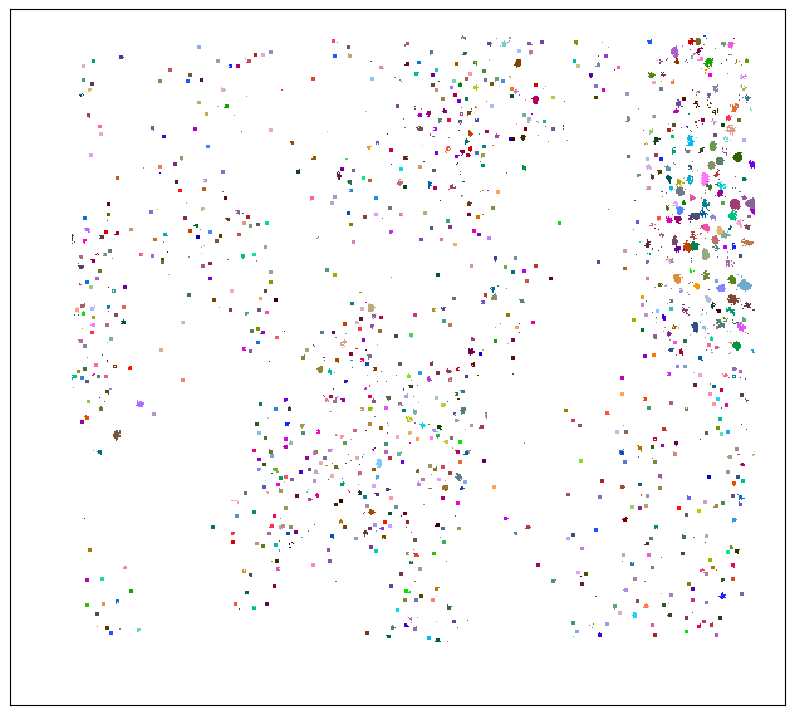

In [66]:
f,ax = plt.subplots(1,1,figsize=(10,10))
# tfu.show_tif(vmap[3],vminmax=(0,0.001),ax=ax)
tfu.show_tif(rgb_vol[3],ax=ax)

In [67]:
import  colorcet
from suite3d import plot_utils as plot
from suite3d import nbtools as nbui


seg = job.load_segmentation_results()


cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], vmap.shape, lam_max=0.075, cmap='cet_glasbey_dark')
nbui.ImageSliceViewer3D(vmap, overlay=rgb_vol,cmap='Greys')

      Loading from /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/rois/info.npy
      Loading from /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-CR031_2024-12-13_1-2/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [30]:
# rois_dir_path = job.combine_patches(n.arange(80), job.dirs['rois'], deduplicate=False,
#                                     parent_dir_name='segmentation', info_use_idx=None)

In [31]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])


KeyError: 'rois'

In [ ]:

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

In [ ]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')